In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import scipy as sp
from typing import List
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

src_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src'
if not src_dir in sys.path: sys.path.append(src_dir)
utils_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src/utils'
if not utils_dir in sys.path: sys.path.append(utils_dir)
from constants import *
from CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from matplotlib.ticker import FormatStrFormatter

from step_7_fit_fp import fit_FP
from step_8_fit_logdist import fit_logdist

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
FP_SETTING = int(os.environ.get('FP_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))

# 1. 6dFGS

Setting 0 = 0.0 | 0.11989778576216455
Setting 1 = 0.0 | 0.12178404920195504


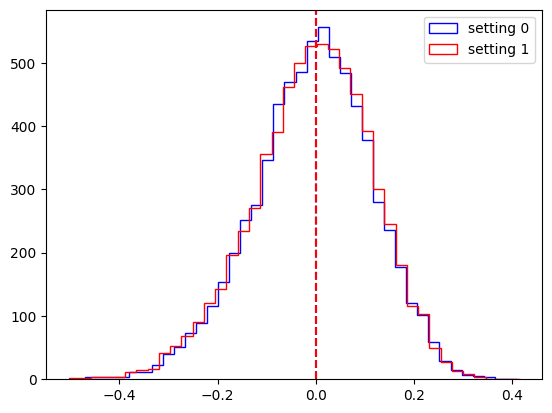

In [19]:
colors = ['b', 'r']

for csetting in [0, 1]:
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{csetting}/fp_setting_0/6dfgs.csv')
    if csetting == 0:
        df['logdist_mean_cf'] -= -0.00600406247767595
    else:
        df['logdist_mean_cf'] -= 0.012104241918052
    
    print(f"Setting {csetting} = {df['logdist_mean_cf'].median()} | {df['logdist_mean_cf'].std()}")
    plt.axvline(x=df['logdist_mean_cf'].median(), c=colors[csetting], ls='--')
    plt.hist(df['logdist_mean_cf'], bins=40, label=f'setting {csetting}', histtype='step', color=colors[csetting])
    plt.legend()

1
Fitting the FP likelihood of 6dFGS
(8, 5216)
==================== a ====================
Mean of a = 1.474
Std of a = 0.0001896932056504361
==================== b ====================
Mean of b = -0.7934
Std of b = 4.569252398879118e-05
==================== c ====================
Mean of c = -0.5514
Std of c = 0.00045138675213169467
==================== rmean ====================
Mean of rmean = 0.0499
Std of rmean = 2.0769329085814172e-05
==================== smean ====================
Mean of smean = 2.2265
Std of smean = 1.9384707146759897e-05
==================== imean ====================
Mean of imean = 3.3779
Std of imean = 2.4923194902977006e-05
==================== sigma1 ====================
Mean of sigma1 = 0.0485
Std of sigma1 = 6.923109695271391e-06
==================== sigma2 ====================
Mean of sigma2 = 0.3207
Std of sigma2 = 2.0769329085814172e-05
==================== sigma3 ====================
Mean of sigma3 = 0.1534
Std of sigma3 = 1.661546326865134e-05




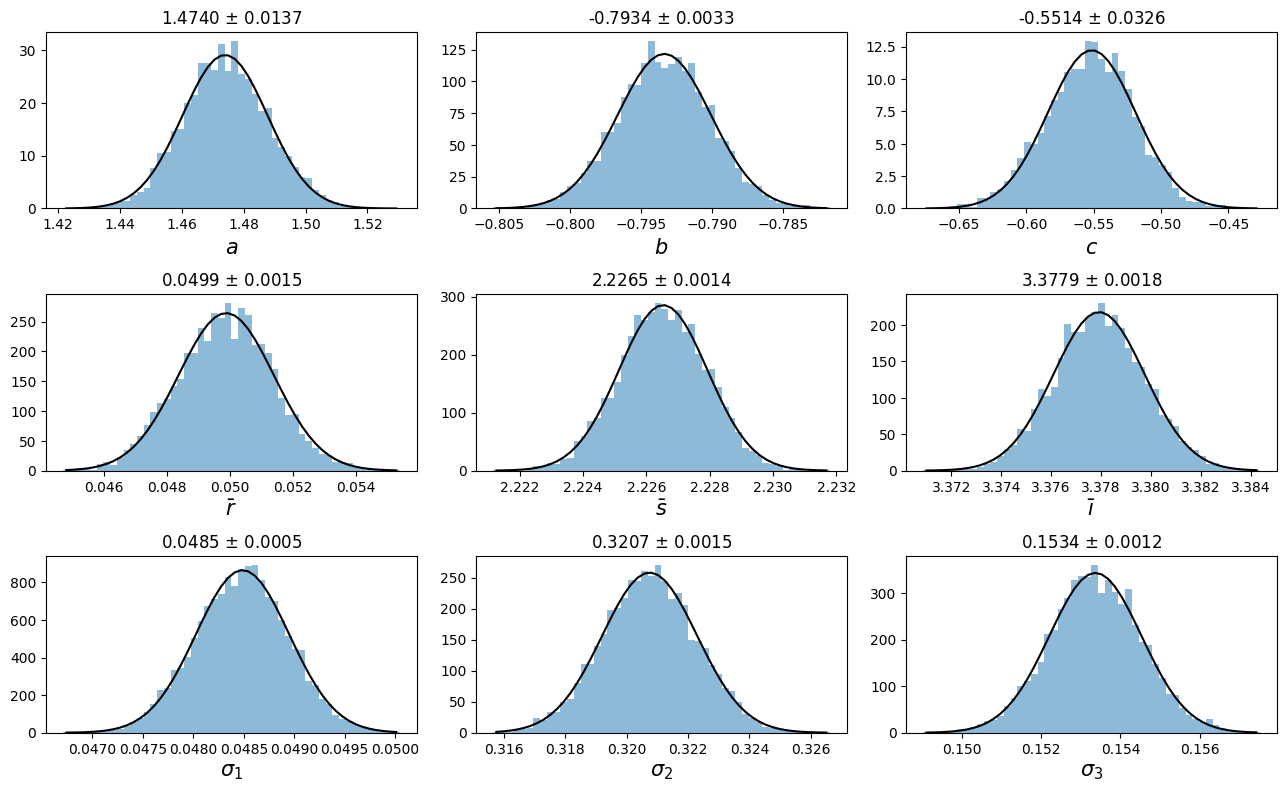

In [25]:
MCMC_CHAIN_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness_setting_{COMPLETENESS_SETTING}/6dfgs_chain.npy'),
    'SDSS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness_setting_{COMPLETENESS_SETTING}/sdss_chain.npy'),
    'LAMOST': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness_setting_{COMPLETENESS_SETTING}/lamost_chain.npy'),
    'ALL_COMBINED': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness_setting_{COMPLETENESS_SETTING}/all_combined_chain.npy')
}

def fit_likelihood() -> None:
    def fit_and_plot(posteriors, fp_paramname, fp_labelname, axis):
        def gaus(x, mu, sig):
            return (1 / np.sqrt(2 * np.pi * sig**2)) * np.exp(-0.5 * ((x - mu) / sig)**2)
        
        xdata = posteriors[fp_paramname]
        y, x_edges = np.histogram(xdata, bins=N, density=True)
        x = (x_edges[1:] + x_edges[:-1])/2
        popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])
        popt[1] = np.absolute(popt[1])
        
        axis.hist(xdata, bins=N, density=True, alpha=0.5)
        axis.plot(x, norm.pdf(x, loc=popt[0], scale=popt[1]), color='black')
        axis.set_xlabel(fp_labelname, fontsize=15)
        axis.set_title(r'%.4f' % popt[0] + ' $\pm$ %.4f' % popt[1])
        print(f"{'=' * 20} {fp_paramname} {'=' * 20}")
        print(f'Mean of {fp_paramname} = {round(popt[0], 4)}')
        print(f'Std of {fp_paramname} = {round(popt[1], 4) / np.sqrt(5216)}')
        fig.tight_layout(pad=1.0)
    
    N = 50
    for survey in ['6dFGS']:
        print(f"Fitting the FP likelihood of {survey}")
        post_dist = np.load(MCMC_CHAIN_OUTPUT_FILEPATH[survey]).T
        print(post_dist.shape)
        posteriors = {
            'a': post_dist[0],
            'b': post_dist[1],
            'c': post_dist[2] - post_dist[0] * post_dist[3] - post_dist[1] * post_dist[4],
            'rmean': post_dist[2],
            'smean': post_dist[3],
            'imean': post_dist[4],
            'sigma1': post_dist[5],
            'sigma2': post_dist[6],
            'sigma3': post_dist[7]
        }
        
        fp_paramname_list = ['a', 'b', 'c', 'rmean', 'smean', 'imean', 'sigma1', 'sigma2', 'sigma3']
        fp_labelname_list = [r'$a$', r'$b$', r'$c$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']
        
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(GOLDEN_RATIO * 8, 8))
        
        for idx, ax in enumerate(fig.axes):
            fit_and_plot(posteriors, fp_paramname_list[idx], fp_labelname_list[idx], ax)
#         fig.savefig(LIKELIHOOD_DIST_IMG_FILEPATH[survey])
        print('\n')

print(COMPLETENESS_SETTING)
fit_likelihood()

### Plot group count vs richness

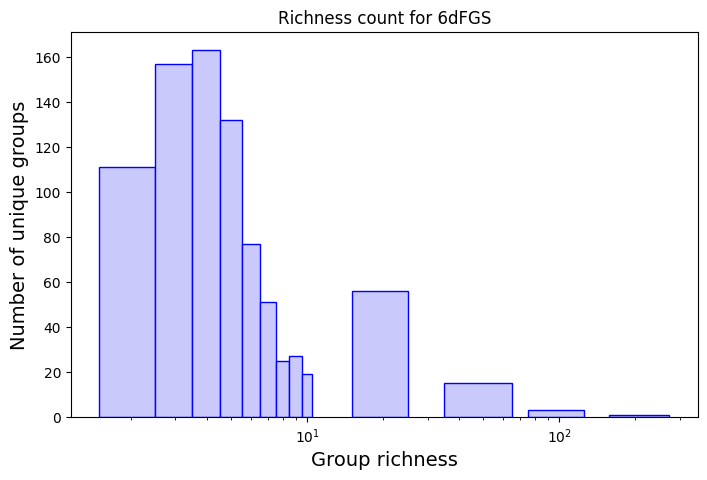

In [166]:
survey = '6dFGS'
COMPLETENESS_SETTING = 0
FP_SETTING = 0

# Select groups and clusters (Nr > 0)
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
df = df[df['Nr'] > 0]

# Bin Nr and count the number of clusters for each Nr
Nr_bin = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 215])
Nr_bin_widths = np.diff(Nr_bin)
Nr_labels = list(range(1, len(Nr_bin)))
df['Nr_bin'] = pd.cut(df['Nr'], bins=Nr_bin, labels=Nr_labels, right=False)

# Group by Nr_bin, count unique number of groups in each bin
df_grouped = df[['Group', 'Nr', 'Nr_bin']].groupby(by='Nr_bin', observed=False).agg(
    grp_count=('Group', 'nunique'),
    Nr_median=('Nr', 'median'),
    Ngal=('Group', 'count')
)
df_grouped['Nr_bin_center'] = 0.5 * (Nr_bin[1:] + Nr_bin[:-1])

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

ax.bar(df_grouped['Nr_bin_center'], df_grouped['grp_count'], width=Nr_bin_widths, align='edge', color='#c9c9fb', edgecolor='b')
ax.set_xscale('log')
ax.set_title(f'Richness count for {survey}')
ax.set_ylabel(r'Number of unique groups', fontsize=14)
ax.set_xlabel(r'Group richness', fontsize=14)

# fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)

plt.show()

### Getting the ideal bins (roughly equal number of groups)

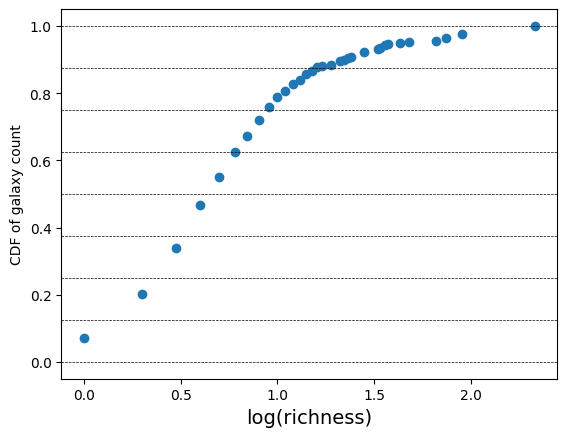

In [293]:
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
df = df[df['Nr'] > 0]

df_grouped = df.groupby(by='Nr', observed=False).agg(
    grp_count=('Group', 'nunique'),
    Ngal=('Nr', 'count')
)

# x: richness in logarithmic scale
x = np.log10(df_grouped.index).to_numpy()
# y: cumulative sum of number of groups (normalized)
y = (df_grouped['Ngal'].cumsum() / df['Group'].count()).to_numpy()

# Create spline interpolation to predict richness
richness_spline = sp.interpolate.splrep(y, x, s=0)

# Calculate the richness bins so the unique group counts are roughly equal
n_bins = 8
bin_edges = np.linspace(0., 1., n_bins + 1)
richness_bins = sp.interpolate.splev(bin_edges, richness_spline, der=0)
# Ceil the values and add 0 at the beginning
richness_bins = np.ceil(10**richness_bins).astype(int)[1:]
richness_bins = np.insert(richness_bins, 0, np.array([0])) + 0.99
richness_bins = np.array(list(dict.fromkeys(richness_bins)))

# Plot the thing
plt.scatter(x, y)
plt.xlabel('log(richness)', fontsize=14)
plt.ylabel(f'CDF of galaxy count')
for i, Nr in enumerate(richness_bins):
    plt.axhline(y=bin_edges[i], ls='--', c='k', lw=0.5)
    
print(richness_bins)

### Plot count and logdist vs richness

/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_4073/2753461756.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['richness_class'] = pd.cut(df_cluster['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=True)


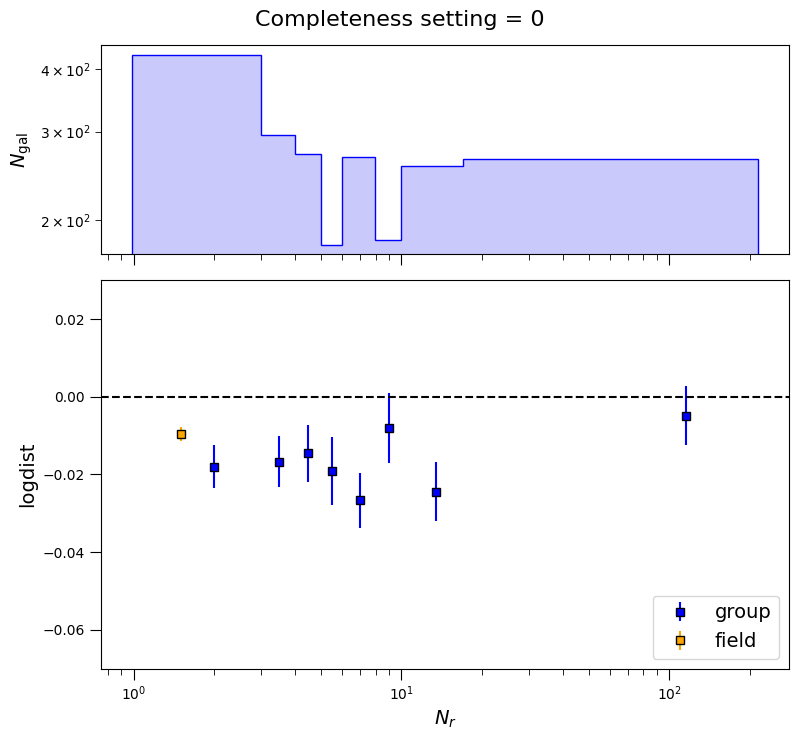

In [295]:
survey = '6dFGS'
COMPLETENESS_SETTING = 0
FP_SETTING = 0

# Load whole dataset
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
df['logdist'] = df['logdist_mean_cf']

# Calculate mean logdist for the singular galaxies (Nr = 0)
df_single = df[df['Nr'] == 0]
single_logdist_mean = df_single['logdist'].mean()
single_logdist_std = df_single['logdist'].std()
single_logdist_stderr = df_single['logdist'].std() / np.sqrt(len(df_single))

# Treat cluster galaxies (Nr >= 1)
df_cluster = df[df['Nr'] > 0]

# Divide into richness classes (10% quantile)
# qcut_, qcut_bins = pd.qcut(x=df_cluster['Nr'], q=8, duplicates='drop', retbins=True)
qcut_bins = richness_bins # Use the ideal bins obtained previously
df_cluster['richness_class'] = pd.cut(df_cluster['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=True)

# Group by class, count each bin and average logdist
df_grouped = df_cluster.groupby(by='richness_class', observed=False).agg(
    group_nunique=('Group', 'nunique'),
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist', 'mean'),
    logdist_rms=('logdist', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df_cluster['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='group')
ax2.errorbar(x=1.5, y=single_logdist_mean, yerr=single_logdist_stderr, fmt='s', mec='k', mfc='orange', ecolor='orange', label='field')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)
ax2.legend(fontsize=14, loc='lower right')

# # Use the same bin edges as Cullan
# richness_bin = [1, 2, 4, 8, 16, 30, 60]
# for x_ in richness_bin:
#     ax2.axvline(x=x_, ls='--', c='k')

fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
fig.tight_layout()

In [296]:
df_grouped

,group_nunique,richness_count,logdist_mean,logdist_rms,bin_center,logdist_mean_stderr
richness_class,,,,,,
1,268,427,-0.018038,0.114602,1.99,0.005546
2,163,295,-0.016699,0.114644,3.49,0.006675
3,132,271,-0.014590,0.120582,4.49,0.007325
4,77,179,-0.019053,0.117819,5.49,0.008806
5,76,267,-0.026635,0.116309,6.99,0.007118
6,46,183,-0.008047,0.123038,8.99,0.009095
7,52,256,-0.024409,0.120152,13.49,0.007509
8,23,265,-0.004907,0.123238,115.49,0.007570


### Logdist vs redshift again

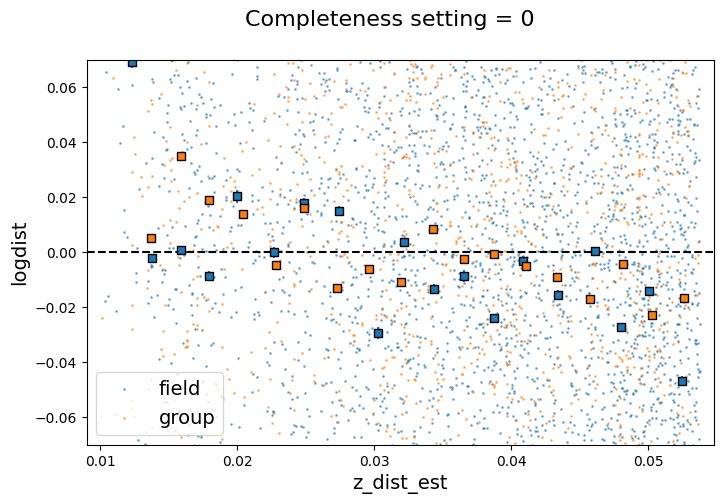

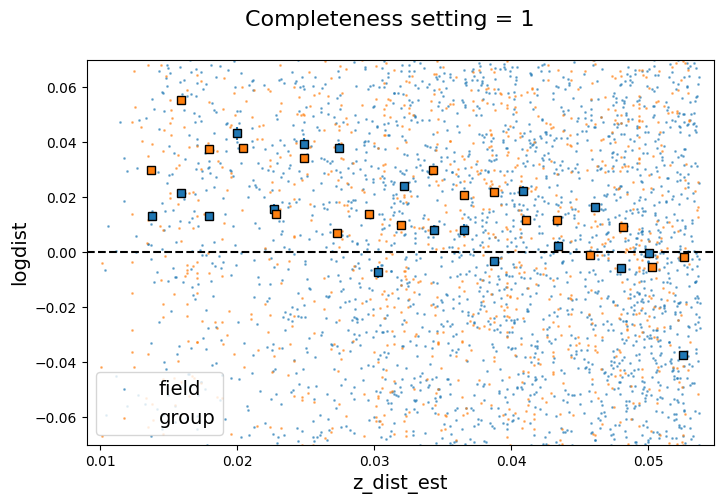

In [305]:
survey = '6dFGS'
COMPLETENESS_SETTING = 0
FP_SETTING = 0

# Redshift bins and labels
bins = np.linspace(ZMIN, ZMAX, 20)
bin_labels = list(range(1, len(bins)))

for COMPLETENESS_SETTING in [0, 1]:
    # Load whole dataset
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
    df['logdist'] = df['logdist_mean_cf']
    df['z_bin'] = pd.cut(df['z_dist_est'], bins=bins, labels=bin_labels)

    # Calculate logdist vs redshift for field galaxies (Nr = 0)
    df_single = df[df['Nr'] == 0]
    df_single_grouped = df_single.groupby(by='z_bin', observed=False).agg(
        z_median=('z_dist_est', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_std=('logdist_std', 'std'),
        Ngal=('z_bin', 'count')
    )
    df_single_grouped['logdist_stderr'] = df_single_grouped['logdist_std'] / np.sqrt(df_single_grouped['Ngal'])

    # Treat cluster galaxies (Nr >= 1)
    df_cluster = df[df['Nr'] > 0]
    df_cluster_grouped = df_cluster.groupby(by='z_bin', observed=False).agg(
        z_median=('z_dist_est', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_std=('logdist_std', 'std'),
        Ngal=('z_bin', 'count')
    )
    df_cluster_grouped['logdist_stderr'] = df_cluster_grouped['logdist_std'] / np.sqrt(df_cluster_grouped['Ngal'])

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.scatter(df_single['z_dist_est'], df_single['logdist'], s=1, c='C0', alpha=0.5, label='field')
    ax.scatter(df_cluster['z_dist_est'], df_cluster['logdist'], s=1, c='C1',alpha=0.5,label='group')
    ax.errorbar(x=df_cluster_grouped['z_median'], y=df_cluster_grouped['logdist_median'], yerr=df_cluster_grouped['logdist_stderr'], fmt='s', mec='k', mfc='C0', ecolor='C0')
    ax.errorbar(x=df_single_grouped['z_median'], y=df_single_grouped['logdist_median'], yerr=df_single_grouped['logdist_stderr'], fmt='s', mec='k', mfc='C1', ecolor='C1')
    ax.axhline(y=0., ls='--', c='k')
    ax.legend(fontsize=14)
    ax.set_xlim(ZMIN - 0.001, ZMAX + 0.001)
    ax.set_ylim(-0.07, 0.07)
    ax.set_xlabel('z_dist_est', fontsize=14)
    ax.set_ylabel('logdist', fontsize=14)
    
    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
    plt.show()

### Fit the FP based on richness

In [298]:
survey = '6dFGS'

for COMPLETENESS_SETTING in [0, 1]:
    FP_FITS_FILEPATH = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

    # Load the post-logdist fit data
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')
    df = df[df['Nr'] > 0]
    df['logdist'] = df['logdist_mean_cf']

    # Use the same bin edges as above
    Nr_bin = richness_bins #np.array([1, 2, 4, 6, 10, 50, 100, 220])
    Nr_bin_widths = np.diff(Nr_bin)
    Nr_labels = list(range(1, len(Nr_bin)))
    df['Nr_bin'] = pd.cut(df['Nr'], bins=Nr_bin, labels=Nr_labels, right=True)

    # Fit the FP for each survey
    FP_params = []
    for bin_label in Nr_labels:
        # Select the richness class
        df_bin = df[df['Nr_bin'] == bin_label]

        # Get completeness setting
        use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
        completeness_model_filepath = os.path.join(ROOT_PATH, 'artifacts/fp_fit/smin_setting_1/completeness.csv') if use_completeness_model else None

        # Get output filepath
        output_filepath = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_sample_final/completeness_setting_{COMPLETENESS_SETTING}/bin_{bin_label}/{survey.lower()}.csv')
        create_parent_folder(output_filepath)

        # Velocity dispersion lower limit
        if survey == 'ALL_COMBINED':
            smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING]['6dFGS']
        else:
            smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        params = fit_FP(
            survey=survey,
            df=df_bin,
            outlier_output_filepath=output_filepath,
            smin=smin,
            use_completeness_model=use_completeness_model,
            completeness_model_filepath=completeness_model_filepath
        )
        params = np.append(params, np.array([len(df_bin)]))
        FP_params.append(params)

    # Convert the FP parameters to dataframe and save to artifacts folder
    FP_params = np.array(FP_params)
    FP_columns = ['a', 'b', 'rmean', 'smean', 'imean', 's1', 's2', 's3', 'Ngal']
    df_fp = pd.DataFrame(FP_params, columns=FP_columns, index=Nr_labels)
    df_fp['Ngal'] = df_fp['Ngal'].astype(int)
    df_fp.index.names = ['bin']
    fp_fits_filepath = FP_FITS_FILEPATH
    create_parent_folder(fp_fits_filepath)
    df_fp.to_csv(fp_fits_filepath)

### Plot FP Parameters trend vs Richness 

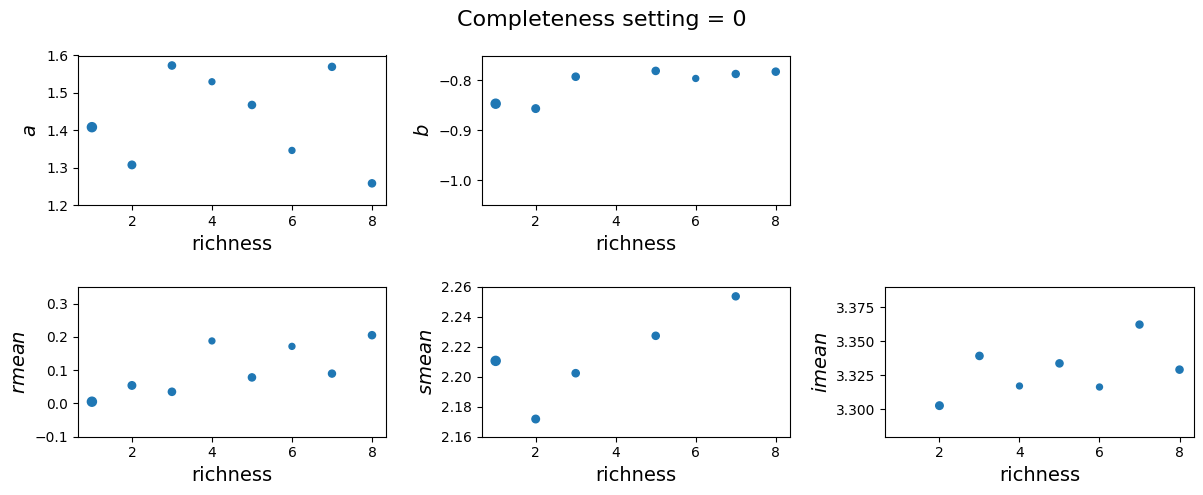

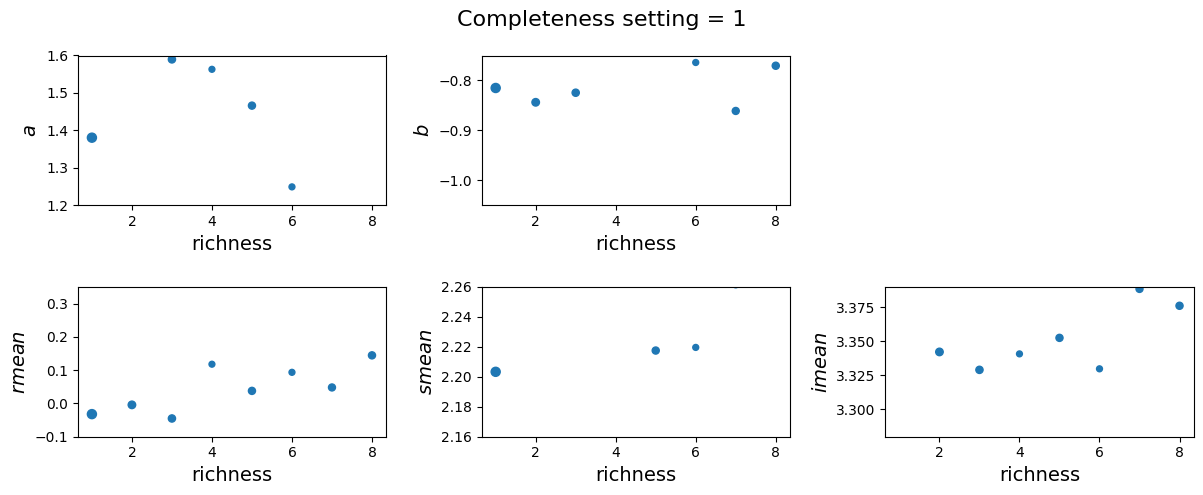

In [299]:
survey = '6dFGS'

for COMPLETENESS_SETTING in [0, 1]:
    df_fp = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

    columns = ['a', 'b', 'rmean', 'smean', 'imean']
    ylims = [(1.2, 1.6), (-1.05, -0.75), (-0.1, 0.35), (2.16, 2.26), (3.28, 3.39)]

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(FIGURE_WIDTH * 1.5, FIGURE_HEIGHT))
    fig.axes[2].remove()

    for i, col in enumerate(columns):
        ax = fig.axes[i]

        ax.scatter(df_fp['bin'], df_fp[col], s=df_fp['Ngal']/10)
        ax.set_ylabel(fr'${col}$', fontsize=14)
        ax.set_xlabel('richness', fontsize=14)
        ax.set_ylim(ylims[i])

    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
    fig.tight_layout(h_pad=2., w_pad=2.)

    plt.show()

### Fit the logdist based on the previous fits

In [300]:
survey = '6dFGS'

for COMPLETENESS_SETTING in [0, 1]:
    # Use the same bin edges as before
    Nr_bin = richness_bins #np.array([1, 2, 4, 6, 10, 50, 100, 220])
    Nr_bin_widths = np.diff(Nr_bin)
    Nr_labels = list(range(1, len(Nr_bin)))

    df_full = pd.DataFrame()
    # Load each bin
    for bin_label in Nr_labels:
        # Load data
        df = pd.read_csv(f'../scrap/richness_experiment/fp_sample_final/completeness_setting_{COMPLETENESS_SETTING}/bin_{bin_label}/{survey.lower()}.csv')

        # Rename logdist column
        df['logdist'] = df['logdist_mean_cf']

        # Load smin
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        # Get the FP parameters to be used for fitting
        FPparams = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv', index_col=0).loc[bin_label].to_numpy()[:-1]

        df = fit_logdist(
            survey=survey,
            df=df,
            smin=smin,
            FPparams=FPparams,
            save_posterior=False
                )

        # Rename logdist column (after richness correction)
        df['logdist_corr'] = df['logdist_mean_cf']

        # Save the output
        logdist_output_path = os.path.join(ROOT_PATH, f'scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')
        create_parent_folder(logdist_output_path)
        df_full = pd.concat([df_full, df])
        df_full.to_csv(logdist_output_path, index=False)

### Create logdist vs richness plot again

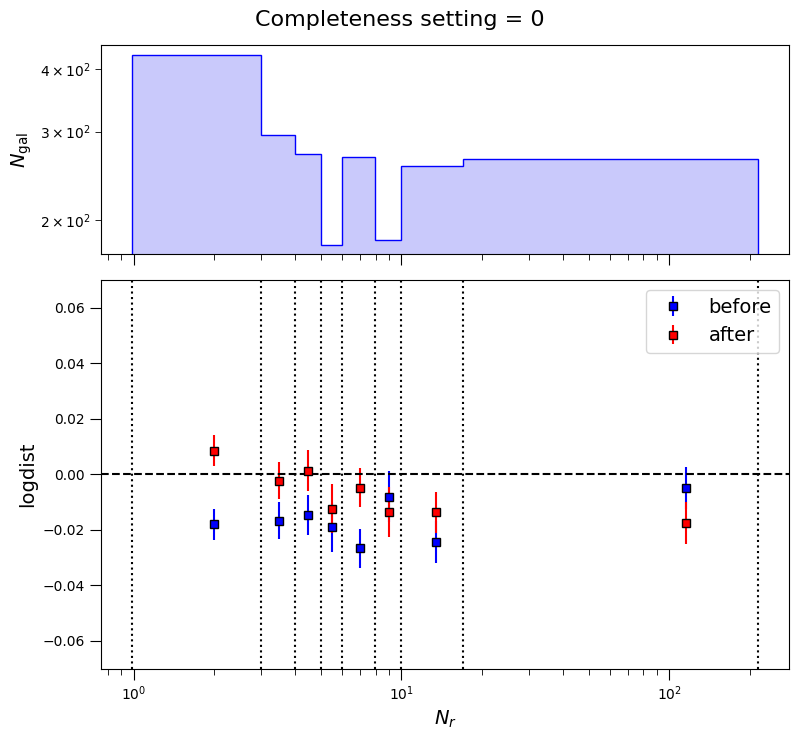

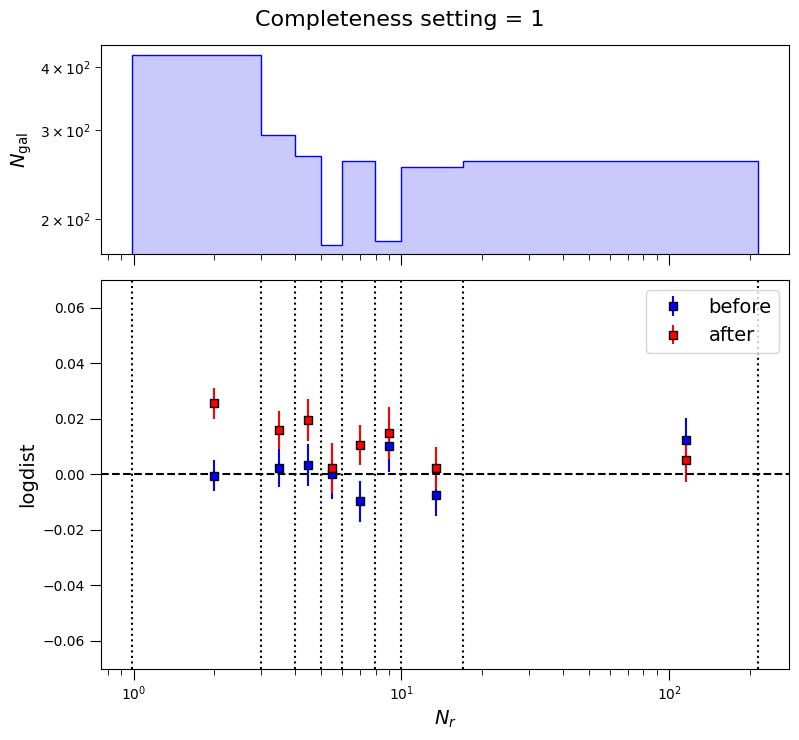

In [304]:
survey = '6dFGS'
COMPLETENESS_SETTING = 0
FP_SETTING = 0

for COMPLETENESS_SETTING in [0, 1]:
    # Load whole dataset
    df = pd.read_csv(f'../scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')
    df['logdist_corr'] = df['logdist_mean_cf']

    # Treat cluster galaxies (Nr >= 1)
    df_cluster = df[df['Nr'] > 0]

    # Divide into richness classes (10% quantile)
    # qcut_, qcut_bins = pd.qcut(x=df_cluster['Nr'], q=8, duplicates='drop', retbins=True)
    qcut_bins = richness_bins # Use the ideal bins obtained previously
    df_cluster['richness_class'] = pd.cut(df_cluster['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

    # Group by class, count each bin and average logdist
    df_grouped = df[['Group', 'Nr', 'Nr_bin', 'logdist', 'logdist_corr']].groupby(by='Nr_bin', observed=False).agg(
        grp_count=('Group', 'nunique'),
        Nr_median=('Nr', 'median'),
        Ngal=('Group', 'count'),
        logdist_mean=('logdist', 'mean'),
        logdist_rms=('logdist', 'std'),
        logdist_corr_mean=('logdist_corr', 'mean'),
        logdist_corr_rms=('logdist_corr', 'std')
    )
    df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['logdist_corr_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['bin_center'] = 0.5 * (Nr_bin[1:] + Nr_bin[:-1])

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                                   gridspec_kw={"height_ratios": (.35, .65)}, 
                                   figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

    # Top figure: histogram of richness
    ax1.hist(df_cluster['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
    ax1.set_yscale('log')
    ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
    ax1.tick_params(axis='both', length=8.0)
    ax1.tick_params(which='minor', length=4.0)

    # Bottom figure: mean logdist vs richness
    ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
    ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_corr_mean'], yerr=df_grouped['logdist_corr_mean_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
    ax2.axhline(y=0, c='k', ls='--')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$N_r$', fontsize=14)
    ax2.set_ylabel(r'logdist', fontsize=14)
    ax2.set_ylim(-0.07, 0.07)
    ax2.tick_params(axis='both', length=8.0)
    ax2.tick_params(which='minor', length=4.0)
    ax2.legend(fontsize=14)

    # # Use the same bin edges as Cullan
    # richness_bin = [1, 2, 4, 8, 16, 30, 60]
    for x_ in richness_bins:
        ax2.axvline(x=x_, ls=':', c='k')

    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
    fig.tight_layout()
    plt.show()

### One last sanity check. Use Cullan's binning

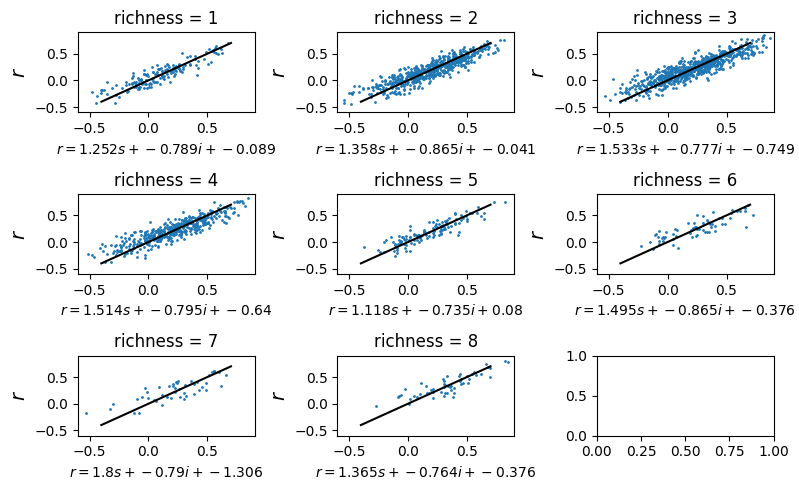

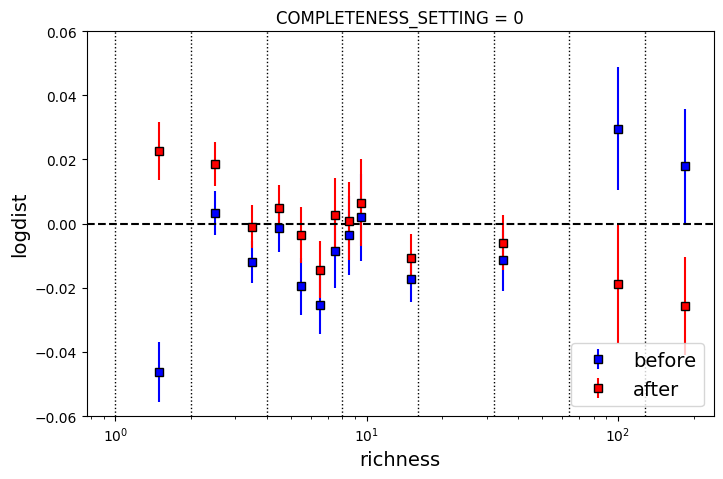

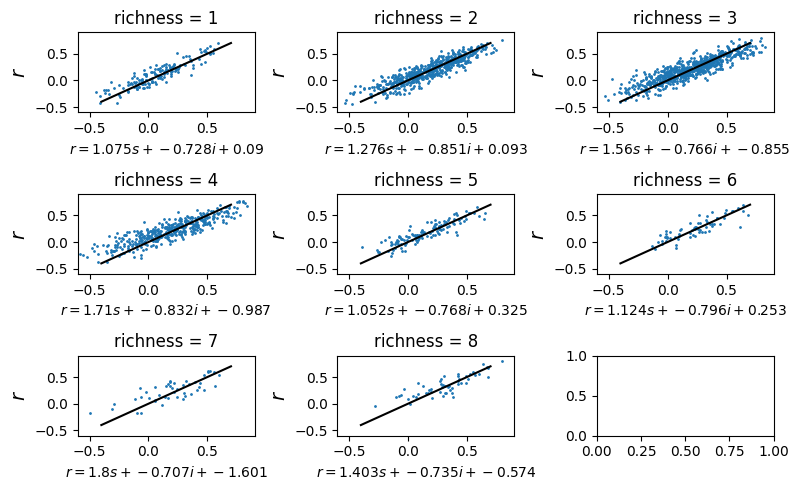

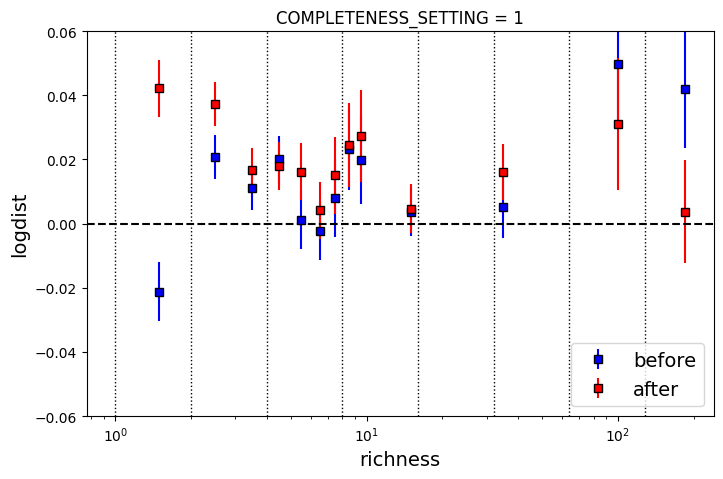

In [130]:
survey = '6dFGS'

# Use the same richness bins that Cullan used (for fitting)
richness_bins = np.array([1, 2, 4, 8, 16, 32, 64, 128, np.inf])

# Use custom richness bins for plotting and aggregation
richness_bins_plot = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 150, 220])

for COMPLETENESS_SETTING in [0, 1]:
    # Load groups and clusters data
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')
    df = df[df['Nr'] > 0]
    df['logdist'] = df['logdist_mean_cf']
    df['logdist_err'] = df['logdist_std_cf']

    # Use the same richness bins that Cullan used
    richness_labels = list(range(1, len(richness_bins)))
    richness_plot_labels = list(range(1, len(richness_bins_plot)))
    df['richness_class'] = pd.cut(df['Nr'], bins=richness_bins, right=False, labels=richness_labels)
    df['richness_plot'] = pd.cut(df['Nr'], bins=richness_bins_plot, right=False, labels=richness_plot_labels)

    # List to store the stuff
    fp_params = []
    df_final = pd.DataFrame()

    # Plot the r vs predicted r
    ncols = 3
    nbins = len(richness_labels)
    nrows = int(np.ceil(nbins / ncols))
    fig, axs = plt.subplots(ncols=3, nrows=nrows, figsize=DEFAULT_FIGSIZE)
    
    # Loop through each richness class
    for i, richness in enumerate(richness_labels):
        df_fit = df.copy()
        df_fit = df_fit[df_fit['richness_class'] == richness]

        # Get veldisp limit
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        # Get completeness setting
        use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
        completeness_model_filepath = f"../artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness.csv" if use_completeness_model else None

        # Fit the FP
        params = fit_FP('6dFGS', df_fit, '../scrap/sampah.csv', smin, use_completeness_model, completeness_model_filepath)
        a, b, rmean, smean, imean, s1, s2, s3 = params
        c = rmean - (a * smean) - (b * imean)
        
        # Plot the r vs predicted r
        ax = fig.axes[i]
        ax.scatter(a * df_fit['s'] + b * df_fit['i'] + c, df_fit['r'], s=1)
        ax.plot([-0.4, 0.7], [-0.4, 0.7], color='k')
        ax.set_xlabel(fr'$r = {np.round(a, 3)}s + {np.round(b, 3)}i + {np.round(c, 3)}$', fontsize=10)
        ax.set_ylabel(r'$r$', fontsize=14)
        ax.set_title(f'richness = {richness}')
        ax.set_xlim(-0.6, 0.9)
        ax.set_ylim(-0.6, 0.9)
        fig.tight_layout()
        
        # Fit the logdist
        df_fit = fit_logdist('6dFGS', df_fit, smin, params)

        # Save the stuff
        fp_params.append(params)
        df_final = pd.concat([df_final, df_fit])

    df_grouped = df_final.groupby(by='richness_plot', observed=False).agg(
        Ngal=('Nr', 'count'),
        richness_median=('Nr', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_corr_median=('logdist_mean_cf', 'median'),
        logdist_std=('logdist', 'std'),
        logdist_corr_std=('logdist_mean_cf', 'std')
    )
    df_grouped['logdist_stderr'] = df_grouped['logdist_std'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['logdist_corr_stderr'] = df_grouped['logdist_corr_std'] / np.sqrt(df_grouped['Ngal'])

    bin_center = (richness_bins_plot[1:] + richness_bins_plot[:-1]) / 2

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.errorbar(bin_center, df_grouped['logdist_median'], yerr=df_grouped['logdist_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
    ax.errorbar(bin_center, df_grouped['logdist_corr_median'], yerr=df_grouped['logdist_corr_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
    ax.set_xscale('log')
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlabel('richness', fontsize=14)
    ax.set_ylabel('logdist', fontsize=14)
    ax.set_title(f'COMPLETENESS_SETTING = {COMPLETENESS_SETTING}')
    ax.set_ylim(-0.06, 0.06)
    ax.legend(fontsize=14, loc='lower right')

    for x_ in richness_bins:
        ax.axvline(x=x_, ls=':', color='k', lw=1)

# 2. SDSS

### Plot group count vs richness

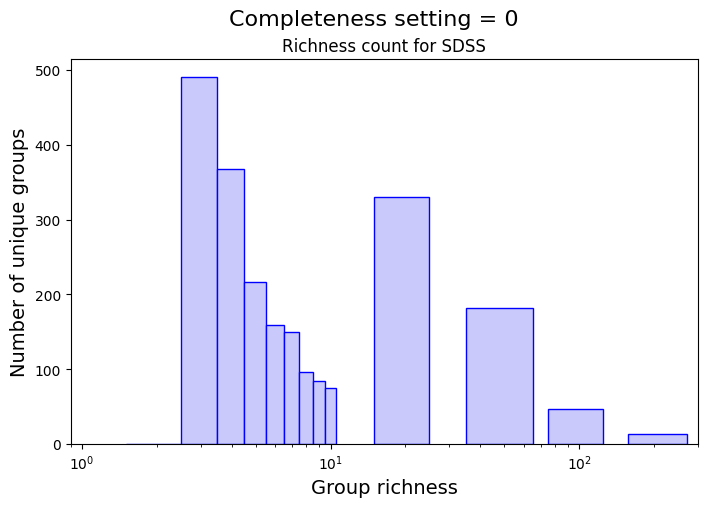

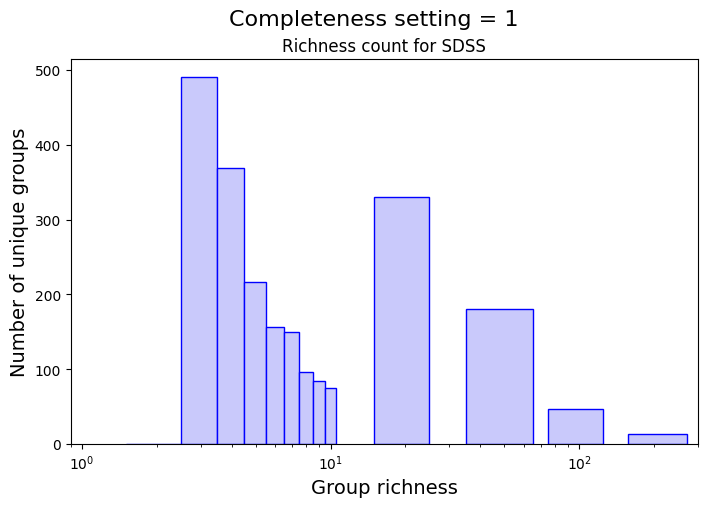

In [10]:
survey = 'SDSS'
FP_SETTING = 0

for COMPLETENESS_SETTING in [0, 1]:
    # Select groups and clusters (Nr > 0)
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
    df = df[df['Group'] != -1]

    # Bin Nr and count the number of clusters for each Nr
    Nr_bin = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 215])
    Nr_bin_widths = np.diff(Nr_bin)
    Nr_labels = list(range(1, len(Nr_bin)))
    df['Nr_bin'] = pd.cut(df['Nr'], bins=Nr_bin, labels=Nr_labels, right=False)

    # Group by Nr_bin, count unique number of groups in each bin
    df_grouped = df[['Group', 'Nr', 'Nr_bin']].groupby(by='Nr_bin', observed=False).agg(
        grp_count=('Group', 'nunique'),
        Nr_median=('Nr', 'median'),
        Ngal=('Group', 'count')
    )
    df_grouped['Nr_bin_center'] = 0.5 * (Nr_bin[1:] + Nr_bin[:-1])

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.bar(df_grouped['Nr_bin_center'], df_grouped['grp_count'], width=Nr_bin_widths, align='edge', color='#c9c9fb', edgecolor='b')
    ax.set_xscale('log')
    ax.set_title(f'Richness count for {survey}')
    ax.set_ylabel(r'Number of unique groups', fontsize=14)
    ax.set_xlabel(r'Group richness', fontsize=14)
    ax.set_xlim(0.9, 300)

    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)

    plt.show()

### Getting the ideal bins (roughly equal number of groups)

[  0.99   1.99   2.99   4.99   6.99   9.99  16.99  37.99 110.99 878.99]


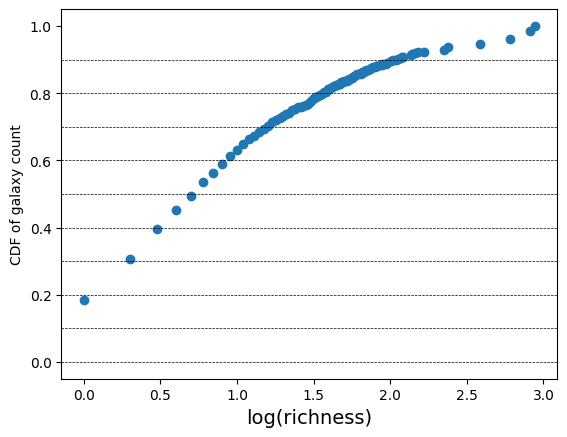

In [69]:
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
# df = df[df['Group'] != -1]

df_grouped = df.groupby(by='Nr', observed=False).agg(
    grp_count=('Group', 'nunique'),
    Ngal=('Nr', 'count')
)

# x: richness in logarithmic scale
x = np.log10(df_grouped.index).to_numpy()
# y: cumulative sum of number of groups (normalized)
y = (df_grouped['Ngal'].cumsum() / df['Group'].count()).to_numpy()

# Create spline interpolation to predict richness
richness_spline = sp.interpolate.splrep(y, x, s=0)

# Calculate the richness bins so the unique group counts are roughly equal
n_bins = 10
bin_edges = np.linspace(0., 1., n_bins + 1)
richness_bins = sp.interpolate.splev(bin_edges, richness_spline, der=0)
# Ceil the values and add 0 at the beginning
richness_bins = np.ceil(10**richness_bins).astype(int)[1:]
richness_bins = np.insert(richness_bins, 0, np.array([0])) + 0.99
richness_bins = np.array(list(dict.fromkeys(richness_bins)))

# Plot the thing
plt.scatter(x, y)
plt.xlabel('log(richness)', fontsize=14)
plt.ylabel(f'CDF of galaxy count')
for i, Nr in enumerate(richness_bins):
    plt.axhline(y=bin_edges[i], ls='--', c='k', lw=0.5)
    
print(richness_bins)

### Plot count and logdist vs richness

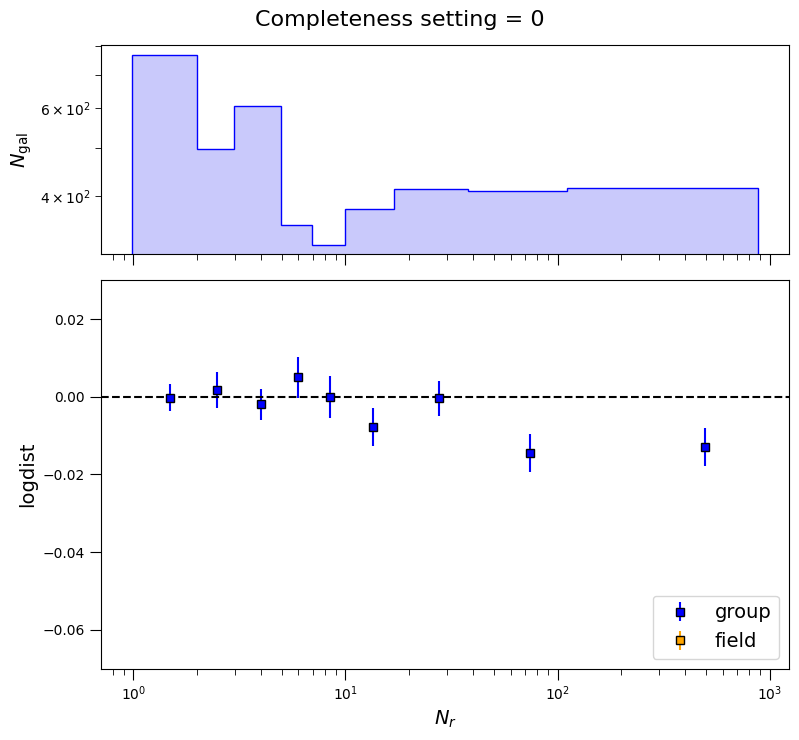

In [70]:
survey = 'SDSS'
COMPLETENESS_SETTING = 0
FP_SETTING = 0

# Load whole dataset
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
df['logdist'] = df['logdist_mean_cf']

# Calculate mean logdist for the singular galaxies (Nr = 0)
df_single = df[df['Nr'] == 0]
single_logdist_mean = df_single['logdist'].mean()
single_logdist_std = df_single['logdist'].std()
single_logdist_stderr = df_single['logdist'].std() / np.sqrt(len(df_single))

# Treat cluster galaxies (Nr >= 1)
df_cluster = df[df['Nr'] > 0]

# Divide into richness classes (10% quantile)
# qcut_, qcut_bins = pd.qcut(x=df_cluster['Nr'], q=8, duplicates='drop', retbins=True)
qcut_bins = richness_bins # Use the ideal bins obtained previously
df_cluster['richness_class'] = pd.cut(df_cluster['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=True)

# Group by class, count each bin and average logdist
df_grouped = df_cluster.groupby(by='richness_class', observed=False).agg(
    group_nunique=('Group', 'nunique'),
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist', 'mean'),
    logdist_rms=('logdist', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df_cluster['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='group')
ax2.errorbar(x=1.5, y=single_logdist_mean, yerr=single_logdist_stderr, fmt='s', mec='k', mfc='orange', ecolor='orange', label='field')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)
ax2.legend(fontsize=14, loc='lower right')

# # Use the same bin edges as Cullan
# richness_bin = [1, 2, 4, 8, 16, 30, 60]
# for x_ in richness_bin:
#     ax2.axvline(x=x_, ls='--', c='k')

fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
fig.tight_layout()

### Logdist vs redshift again

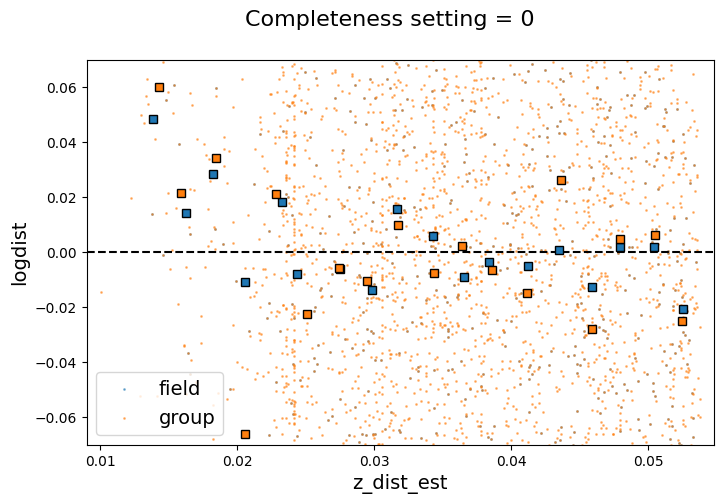

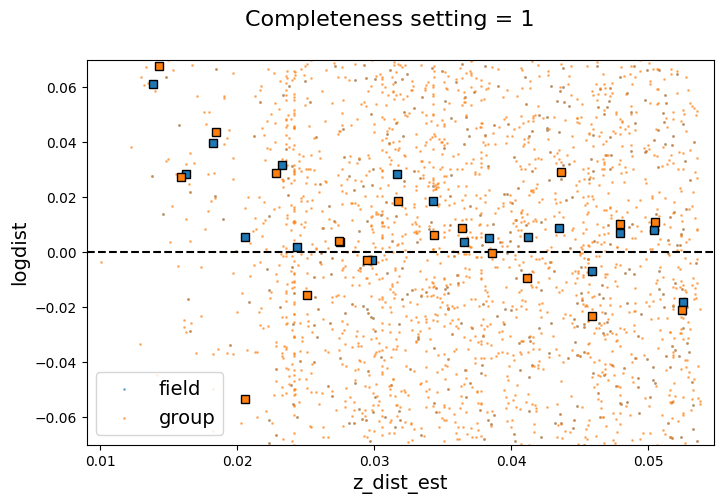

In [71]:
survey = 'SDSS'
FP_SETTING = 0

# Redshift bins and labels
bins = np.linspace(ZMIN, ZMAX, 20)
bin_labels = list(range(1, len(bins)))

for COMPLETENESS_SETTING in [0, 1]:
    # Load whole dataset
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
    df['logdist'] = df['logdist_mean_cf']
    df['z_bin'] = pd.cut(df['z_dist_est'], bins=bins, labels=bin_labels)

    # Calculate logdist vs redshift for field galaxies (Nr = 0)
    df_single = df[df['Group'] == -1]
    df_single_grouped = df_single.groupby(by='z_bin', observed=False).agg(
        z_median=('z_dist_est', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_std=('logdist_std', 'std'),
        Ngal=('z_bin', 'count')
    )
    df_single_grouped['logdist_stderr'] = df_single_grouped['logdist_std'] / np.sqrt(df_single_grouped['Ngal'])

    # Treat cluster galaxies (Nr >= 1)
    df_cluster = df[df['Nr'] > 0]
    df_cluster_grouped = df_cluster.groupby(by='z_bin', observed=False).agg(
        z_median=('z_dist_est', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_std=('logdist_std', 'std'),
        Ngal=('z_bin', 'count')
    )
    df_cluster_grouped['logdist_stderr'] = df_cluster_grouped['logdist_std'] / np.sqrt(df_cluster_grouped['Ngal'])

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.scatter(df_single['z_dist_est'], df_single['logdist'], s=1, c='C0', alpha=0.5, label='field')
    ax.scatter(df_cluster['z_dist_est'], df_cluster['logdist'], s=1, c='C1',alpha=0.5,label='group')
    ax.errorbar(x=df_cluster_grouped['z_median'], y=df_cluster_grouped['logdist_median'], yerr=df_cluster_grouped['logdist_stderr'], fmt='s', mec='k', mfc='C0', ecolor='C0')
    ax.errorbar(x=df_single_grouped['z_median'], y=df_single_grouped['logdist_median'], yerr=df_single_grouped['logdist_stderr'], fmt='s', mec='k', mfc='C1', ecolor='C1')
    ax.axhline(y=0., ls='--', c='k')
    ax.legend(fontsize=14)
    ax.set_xlim(ZMIN - 0.001, ZMAX + 0.001)
    ax.set_ylim(-0.07, 0.07)
    ax.set_xlabel('z_dist_est', fontsize=14)
    ax.set_ylabel('logdist', fontsize=14)
    
    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
    plt.show()

### Fit the FP based on richness

In [72]:
survey = 'SDSS'

for COMPLETENESS_SETTING in [0, 1]:
    FP_FITS_FILEPATH = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

    # Load the post-logdist fit data
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')
    df = df[df['Nr'] > 0]
    df['logdist'] = df['logdist_mean_cf']

    # Use the same bin edges as above
    Nr_bin = richness_bins #np.array([1, 2, 4, 6, 10, 50, 100, 220])
    Nr_bin_widths = np.diff(Nr_bin)
    Nr_labels = list(range(1, len(Nr_bin)))
    df['Nr_bin'] = pd.cut(df['Nr'], bins=Nr_bin, labels=Nr_labels, right=True)

    # Fit the FP for each survey
    FP_params = []
    for bin_label in Nr_labels:
        # Select the richness class
        df_bin = df[df['Nr_bin'] == bin_label]

        # Get completeness setting
        use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
        completeness_model_filepath = os.path.join(ROOT_PATH, 'artifacts/fp_fit/smin_setting_1/completeness.csv') if use_completeness_model else None

        # Get output filepath
        output_filepath = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_sample_final/completeness_setting_{COMPLETENESS_SETTING}/bin_{bin_label}/{survey.lower()}.csv')
        create_parent_folder(output_filepath)

        # Velocity dispersion lower limit
        if survey == 'ALL_COMBINED':
            smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING]['6dFGS']
        else:
            smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        params = fit_FP(
            survey=survey,
            df=df_bin,
            outlier_output_filepath=output_filepath,
            smin=smin,
            use_completeness_model=use_completeness_model,
            completeness_model_filepath=completeness_model_filepath
        )
        params = np.append(params, np.array([len(df_bin)]))
        FP_params.append(params)

    # Convert the FP parameters to dataframe and save to artifacts folder
    FP_params = np.array(FP_params)
    FP_columns = ['a', 'b', 'rmean', 'smean', 'imean', 's1', 's2', 's3', 'Ngal']
    df_fp = pd.DataFrame(FP_params, columns=FP_columns, index=Nr_labels)
    df_fp['Ngal'] = df_fp['Ngal'].astype(int)
    df_fp.index.names = ['bin']
    fp_fits_filepath = FP_FITS_FILEPATH
    create_parent_folder(fp_fits_filepath)
    df_fp.to_csv(fp_fits_filepath)

### Plot FP Parameters trend vs Richness 

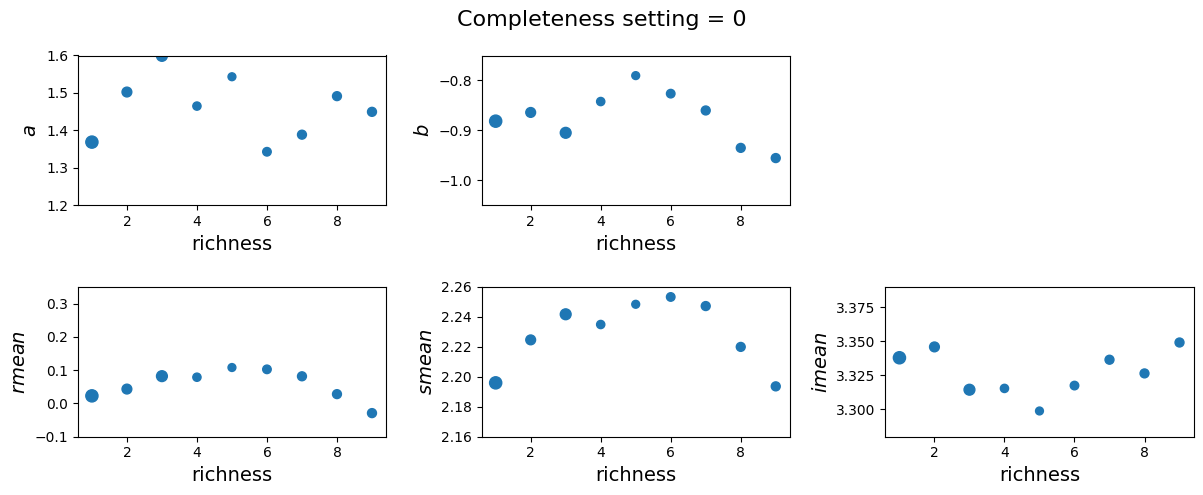

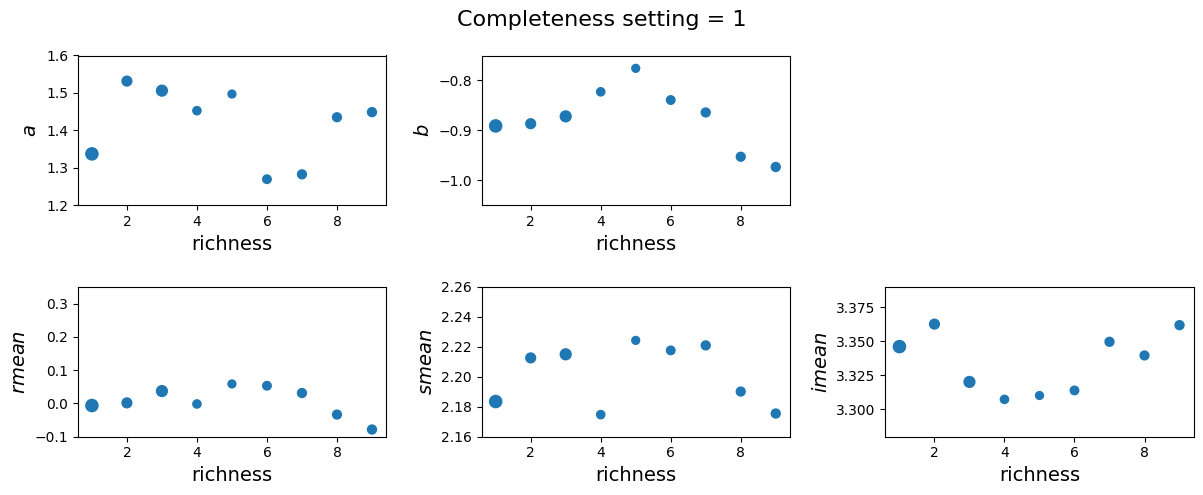

In [73]:
survey = 'SDSS'

for COMPLETENESS_SETTING in [0, 1]:
    df_fp = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

    columns = ['a', 'b', 'rmean', 'smean', 'imean']
    ylims = [(1.2, 1.6), (-1.05, -0.75), (-0.1, 0.35), (2.16, 2.26), (3.28, 3.39)]

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(FIGURE_WIDTH * 1.5, FIGURE_HEIGHT))
    fig.axes[2].remove()

    for i, col in enumerate(columns):
        ax = fig.axes[i]

        ax.scatter(df_fp['bin'], df_fp[col], s=df_fp['Ngal']/10)
        ax.set_ylabel(fr'${col}$', fontsize=14)
        ax.set_xlabel('richness', fontsize=14)
        ax.set_ylim(ylims[i])

    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
    fig.tight_layout(h_pad=2., w_pad=2.)

    plt.show()

### Fit the logdist based on the previous fits

In [74]:
survey = 'SDSS'

for COMPLETENESS_SETTING in [0, 1]:
    # Use the same bin edges as before
    Nr_bin = richness_bins #np.array([1, 2, 4, 6, 10, 50, 100, 220])
    Nr_bin_widths = np.diff(Nr_bin)
    Nr_labels = list(range(1, len(Nr_bin)))

    df_full = pd.DataFrame()
    # Load each bin
    for bin_label in Nr_labels:
        # Load data
        df = pd.read_csv(f'../scrap/richness_experiment/fp_sample_final/completeness_setting_{COMPLETENESS_SETTING}/bin_{bin_label}/{survey.lower()}.csv')

        # Rename logdist column
        df['logdist'] = df['logdist_mean_cf']

        # Load smin
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        # Get the FP parameters to be used for fitting
        FPparams = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv', index_col=0).loc[bin_label].to_numpy()[:-1]

        df = fit_logdist(
            survey=survey,
            df=df,
            smin=smin,
            FPparams=FPparams,
            save_posterior=False
                )

        # Rename logdist column (after richness correction)
        df['logdist_corr'] = df['logdist_mean_cf']

        # Save the output
        logdist_output_path = os.path.join(ROOT_PATH, f'scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')
        create_parent_folder(logdist_output_path)
        df_full = pd.concat([df_full, df])
        df_full.to_csv(logdist_output_path, index=False)

### Create logdist vs richness plot again

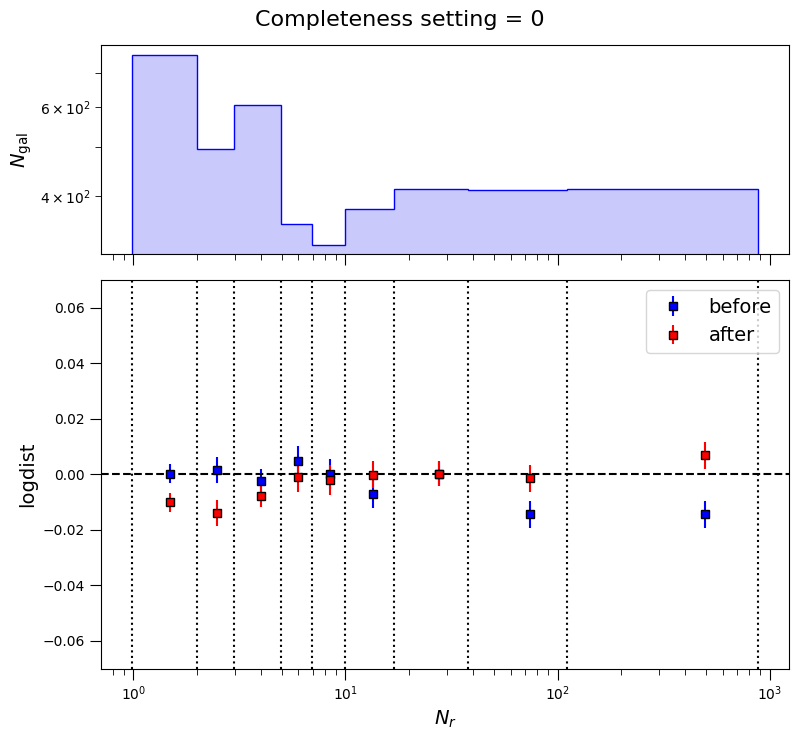

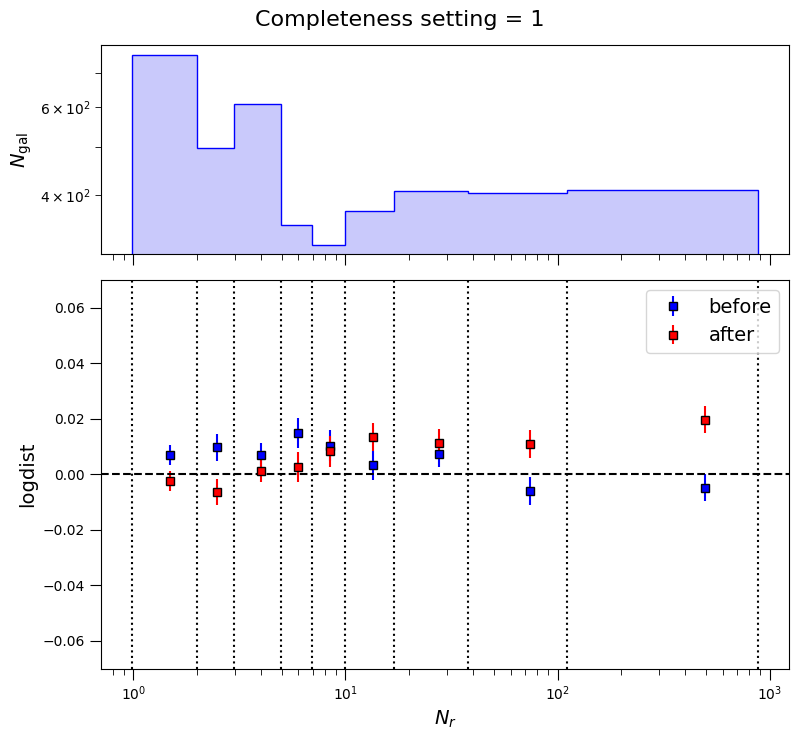

In [75]:
survey = 'SDSS'
FP_SETTING = 0

for COMPLETENESS_SETTING in [0, 1]:
    # Load whole dataset
    df = pd.read_csv(f'../scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')
    df['logdist_corr'] = df['logdist_mean_cf']

    # Treat cluster galaxies (Nr >= 1)
    df_cluster = df[df['Nr'] > 0]

    # Divide into richness classes (10% quantile)
    # qcut_, qcut_bins = pd.qcut(x=df_cluster['Nr'], q=8, duplicates='drop', retbins=True)
    qcut_bins = richness_bins # Use the ideal bins obtained previously
    df_cluster['richness_class'] = pd.cut(df_cluster['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

    # Group by class, count each bin and average logdist
    df_grouped = df[['Group', 'Nr', 'Nr_bin', 'logdist', 'logdist_corr']].groupby(by='Nr_bin', observed=False).agg(
        grp_count=('Group', 'nunique'),
        Nr_median=('Nr', 'median'),
        Ngal=('Group', 'count'),
        logdist_mean=('logdist', 'mean'),
        logdist_rms=('logdist', 'std'),
        logdist_corr_mean=('logdist_corr', 'mean'),
        logdist_corr_rms=('logdist_corr', 'std')
    )
    df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['logdist_corr_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['bin_center'] = 0.5 * (Nr_bin[1:] + Nr_bin[:-1])

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                                   gridspec_kw={"height_ratios": (.35, .65)}, 
                                   figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

    # Top figure: histogram of richness
    ax1.hist(df_cluster['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
    ax1.set_yscale('log')
    ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
    ax1.tick_params(axis='both', length=8.0)
    ax1.tick_params(which='minor', length=4.0)

    # Bottom figure: mean logdist vs richness
    ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
    ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_corr_mean'], yerr=df_grouped['logdist_corr_mean_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
    ax2.axhline(y=0, c='k', ls='--')
    ax2.set_xscale('log')
    ax2.set_xlabel(r'$N_r$', fontsize=14)
    ax2.set_ylabel(r'logdist', fontsize=14)
    ax2.set_ylim(-0.07, 0.07)
    ax2.tick_params(axis='both', length=8.0)
    ax2.tick_params(which='minor', length=4.0)
    ax2.legend(fontsize=14)

    # # Use the same bin edges as Cullan
    # richness_bin = [1, 2, 4, 8, 16, 30, 60]
    for x_ in richness_bins:
        ax2.axvline(x=x_, ls=':', c='k')

    fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
    fig.tight_layout()
    plt.show()

In [76]:
df_grouped

,grp_count,Nr_median,Ngal,logdist_mean,logdist_rms,logdist_corr_mean,logdist_corr_rms,logdist_mean_stderr,logdist_corr_mean_stderr,bin_center
Nr_bin,,,,,,,,,,
1,1,1.0,763,0.006945,0.097752,-0.002410,0.095694,0.003539,0.003539,1.49
2,490,2.0,496,0.009723,0.106679,-0.006418,0.114547,0.004790,0.004790,2.49
3,584,3.0,607,0.006988,0.103224,0.001307,0.103278,0.004190,0.004190,3.99
4,307,6.0,349,0.014986,0.100594,0.002796,0.099321,0.005385,0.005385,5.99
5,256,8.0,319,0.010391,0.099847,0.008415,0.092086,0.005590,0.005590,8.49
6,273,12.0,373,0.003278,0.099036,0.013497,0.088221,0.005128,0.005128,13.49
7,195,24.0,408,0.007492,0.096556,0.011427,0.090252,0.004780,0.004780,27.49
8,91,58.0,405,-0.005910,0.102853,0.010953,0.102936,0.005111,0.005111,74.49
9,16,606.0,410,-0.004741,0.098864,0.019698,0.101292,0.004883,0.004883,494.99


### One last sanity check. Use Cullan's binning

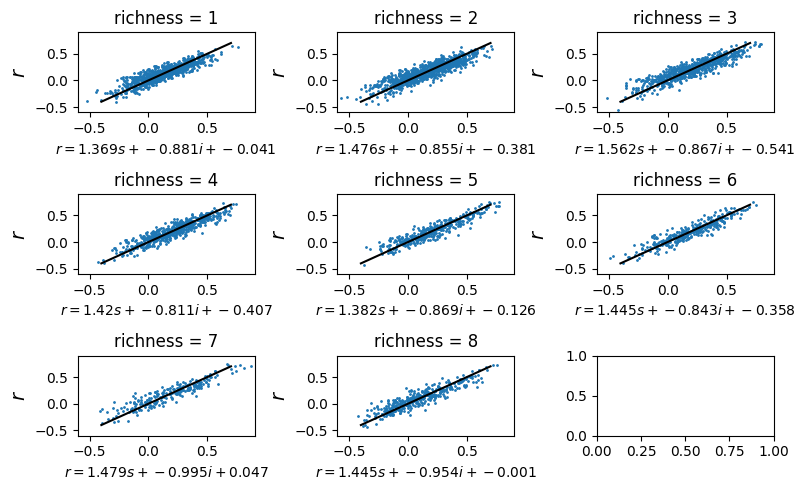

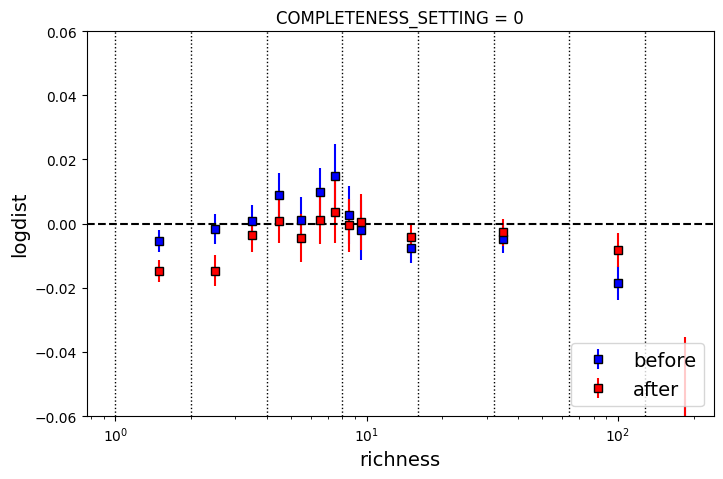

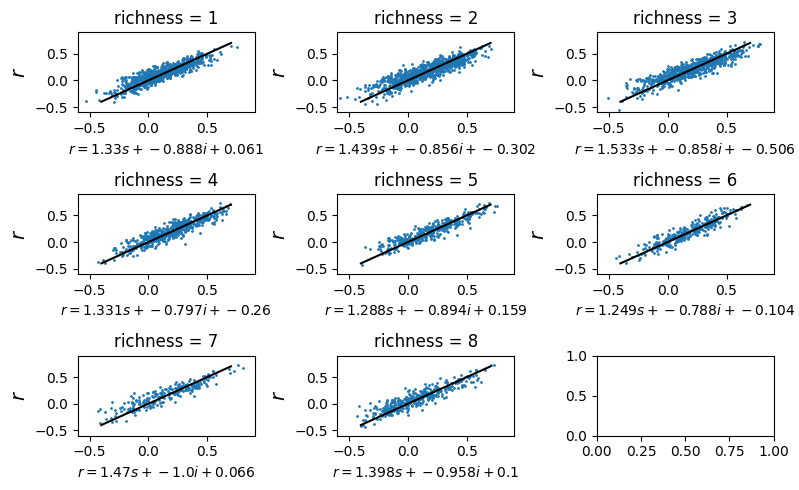

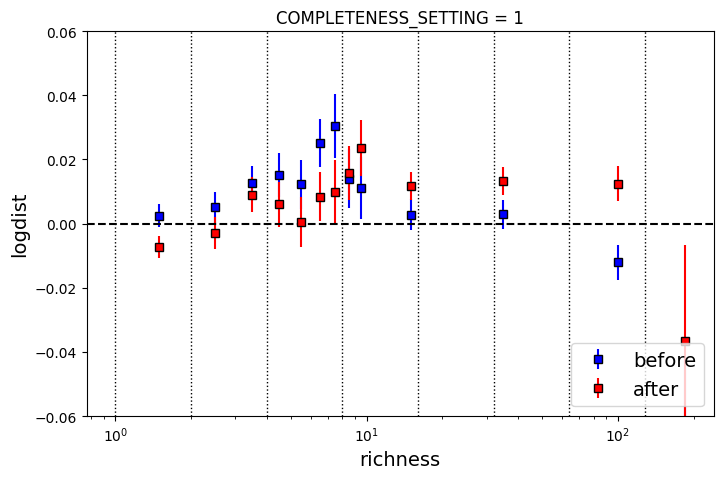

In [131]:
survey = 'SDSS'

# Use the same richness bins that Cullan used (for fitting)
richness_bins = np.array([1, 2, 4, 8, 16, 32, 64, 128, np.inf])

# Use custom richness bins for plotting and aggregation
richness_bins_plot = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 150, 220])

for COMPLETENESS_SETTING in [0, 1]:
    # Load groups and clusters data
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')
    df = df[df['Nr'] > 0]
    df['logdist'] = df['logdist_mean_cf']
    df['logdist_err'] = df['logdist_std_cf']

    # Use the same richness bins that Cullan used
    richness_labels = list(range(1, len(richness_bins)))
    richness_plot_labels = list(range(1, len(richness_bins_plot)))
    df['richness_class'] = pd.cut(df['Nr'], bins=richness_bins, right=False, labels=richness_labels)
    df['richness_plot'] = pd.cut(df['Nr'], bins=richness_bins_plot, right=False, labels=richness_plot_labels)

    # List to store the stuff
    fp_params = []
    df_final = pd.DataFrame()

    # Plot the r vs predicted r
    ncols = 3
    nbins = len(richness_labels)
    nrows = int(np.ceil(nbins / ncols))
    fig, axs = plt.subplots(ncols=3, nrows=nrows, figsize=DEFAULT_FIGSIZE)
    
    # Loop through each richness class
    for i, richness in enumerate(richness_labels):
        df_fit = df.copy()
        df_fit = df_fit[df_fit['richness_class'] == richness]

        # Get veldisp limit
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        # Get completeness setting
        use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
        completeness_model_filepath = f"../artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness.csv" if use_completeness_model else None

        # Fit the FP
        params = fit_FP('6dFGS', df_fit, '../scrap/sampah.csv', smin, use_completeness_model, completeness_model_filepath)
        a, b, rmean, smean, imean, s1, s2, s3 = params
        c = rmean - (a * smean) - (b * imean)
        
        # Plot the r vs predicted r
        ax = fig.axes[i]
        ax.scatter(a * df_fit['s'] + b * df_fit['i'] + c, df_fit['r'], s=1)
        ax.plot([-0.4, 0.7], [-0.4, 0.7], color='k')
        ax.set_xlabel(fr'$r = {np.round(a, 3)}s + {np.round(b, 3)}i + {np.round(c, 3)}$', fontsize=10)
        ax.set_ylabel(r'$r$', fontsize=14)
        ax.set_title(f'richness = {richness}')
        ax.set_xlim(-0.6, 0.9)
        ax.set_ylim(-0.6, 0.9)
        fig.tight_layout()
        
        # Fit the logdist
        df_fit = fit_logdist('6dFGS', df_fit, smin, params)

        # Save the stuff
        fp_params.append(params)
        df_final = pd.concat([df_final, df_fit])

    df_grouped = df_final.groupby(by='richness_plot', observed=False).agg(
        Ngal=('Nr', 'count'),
        richness_median=('Nr', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_corr_median=('logdist_mean_cf', 'median'),
        logdist_std=('logdist', 'std'),
        logdist_corr_std=('logdist_mean_cf', 'std')
    )
    df_grouped['logdist_stderr'] = df_grouped['logdist_std'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['logdist_corr_stderr'] = df_grouped['logdist_corr_std'] / np.sqrt(df_grouped['Ngal'])

    bin_center = (richness_bins_plot[1:] + richness_bins_plot[:-1]) / 2

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.errorbar(bin_center, df_grouped['logdist_median'], yerr=df_grouped['logdist_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
    ax.errorbar(bin_center, df_grouped['logdist_corr_median'], yerr=df_grouped['logdist_corr_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
    ax.set_xscale('log')
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlabel('richness', fontsize=14)
    ax.set_ylabel('logdist', fontsize=14)
    ax.set_title(f'COMPLETENESS_SETTING = {COMPLETENESS_SETTING}')
    ax.set_ylim(-0.06, 0.06)
    ax.legend(fontsize=14, loc='lower right')

    for x_ in richness_bins:
        ax.axvline(x=x_, ls=':', color='k', lw=1)

# ------------------------ BATAS SUCI (DEPRECATED) ------------------------

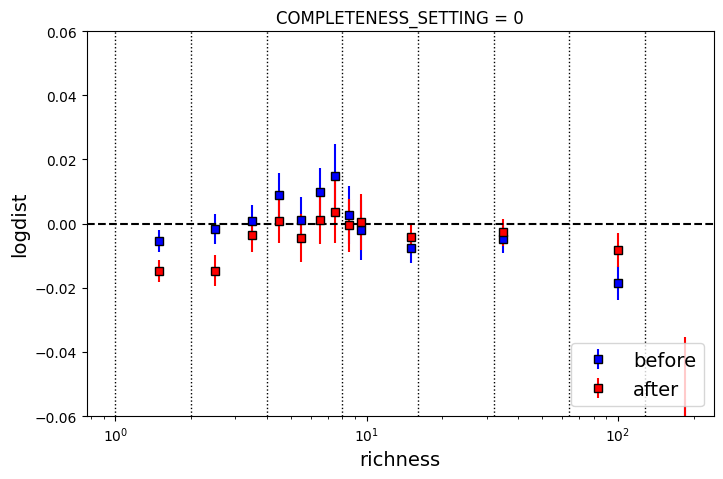

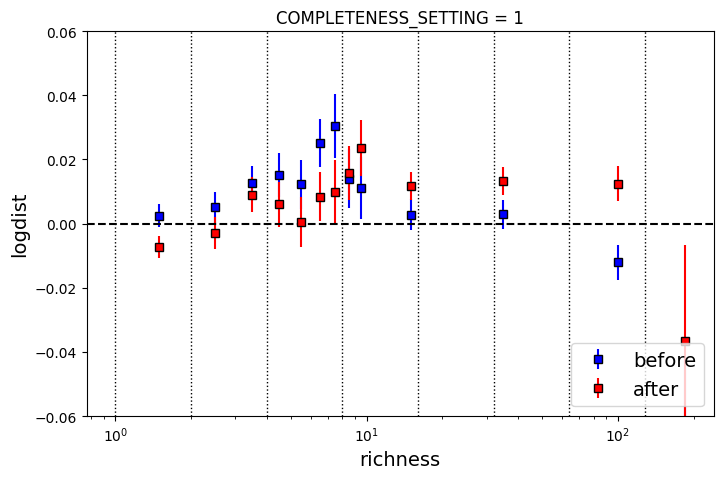

In [40]:
survey = 'SDSS'

# Use the same richness bins that Cullan used (for fitting)
richness_bins = np.array([1, 2, 4, 8, 16, 32, 64, 128, np.inf])

# Use custom richness bins for plotting and aggregation
richness_bins_plot = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 150, 220])

for COMPLETENESS_SETTING in [0, 1]:
    # Load groups and clusters data
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')
    df = df[df['Nr'] > 0]
    df['logdist'] = df['logdist_mean_cf']
    df['logdist_err'] = df['logdist_std_cf']

    # Use the same richness bins that Cullan used
    richness_labels = list(range(1, len(richness_bins)))
    richness_plot_labels = list(range(1, len(richness_bins_plot)))
    df['richness_class'] = pd.cut(df['Nr'], bins=richness_bins, right=False, labels=richness_labels)
    df['richness_plot'] = pd.cut(df['Nr'], bins=richness_bins_plot, right=False, labels=richness_plot_labels)

    # List to store the stuff
    fp_params = []
    df_final = pd.DataFrame()

    # Loop through each richness class
    for i in richness_labels[:1]:
        df_fit = df.copy()
        df_fit = df_fit[df_fit['richness_class'] == i]

        # Get veldisp limit
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        # Get completeness setting
        use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
        completeness_model_filepath = f"../artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness.csv" if use_completeness_model else None

        # Fit the FP
        params = fit_FP('6dFGS', df_fit, '../scrap/sampah.csv', smin, use_completeness_model, completeness_model_filepath)

        # Fit the logdist
        df_fit = fit_logdist('6dFGS', df_fit, smin, params)

        # Save the stuff
        fp_params.append(params)
        df_final = pd.concat([df_final, df_fit])

    df_grouped = df_final.groupby(by='richness_plot', observed=False).agg(
        Ngal=('Nr', 'count'),
        richness_median=('Nr', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_corr_median=('logdist_mean_cf', 'median'),
        logdist_std=('logdist', 'std'),
        logdist_corr_std=('logdist_mean_cf', 'std')
    )
    df_grouped['logdist_stderr'] = df_grouped['logdist_std'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['logdist_corr_stderr'] = df_grouped['logdist_corr_std'] / np.sqrt(df_grouped['Ngal'])

    bin_center = (richness_bins_plot[1:] + richness_bins_plot[:-1]) / 2

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.errorbar(bin_center, df_grouped['logdist_median'], yerr=df_grouped['logdist_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
    ax.errorbar(bin_center, df_grouped['logdist_corr_median'], yerr=df_grouped['logdist_corr_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
    ax.set_xscale('log')
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlabel('richness', fontsize=14)
    ax.set_ylabel('logdist', fontsize=14)
    ax.set_title(f'COMPLETENESS_SETTING = {COMPLETENESS_SETTING}')
    ax.set_ylim(-0.06, 0.06)
    ax.legend(fontsize=14, loc='lower right')

    for x_ in richness_bins:
        ax.axvline(x=x_, ls=':', color='k', lw=1)

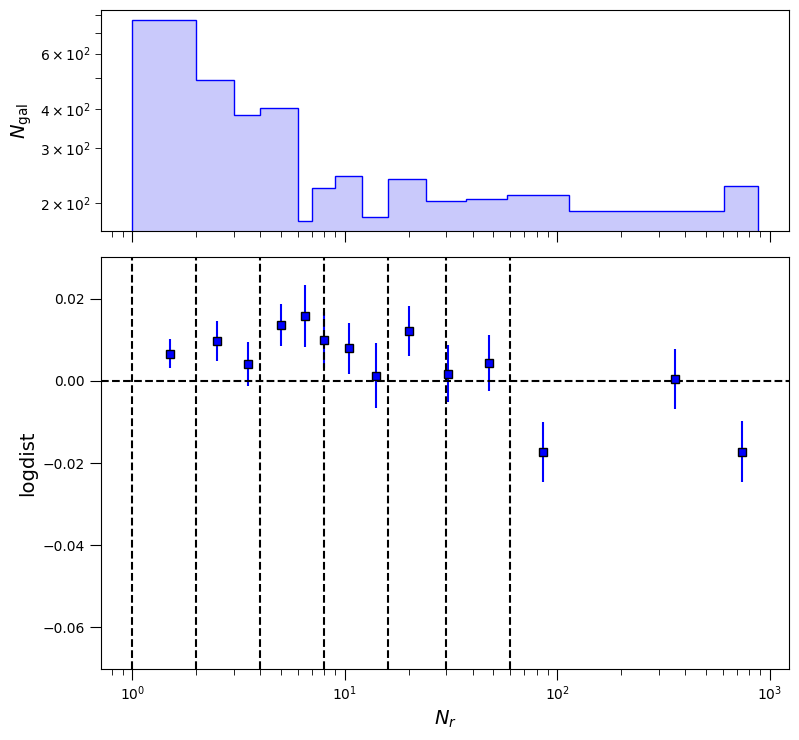

In [2]:
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/completeness_setting_1/fp_setting_0/sdss.csv')

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=20, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist_mean_cf', 'mean'),
    logdist_rms=('logdist_mean_cf', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)

# Use the same bin edges as Cullan
richness_bin = [1, 2, 4, 8, 16, 30, 60]
for x_ in richness_bin:
    ax2.axvline(x=x_, ls='--', c='k')

fig.tight_layout()

### Fit the FP based on richness

In [73]:
survey = 'SDSS'

COMPLETENESS_SETTING = 1

FP_FITS_FILEPATH = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

# Load the post-logdist fit data
df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')

# Use the same bin edges as Cullan
richness_bins = [1, 2, 4, 8, 16, 30, 60, np.inf]
richness_labels = list(range(1, len(richness_bins)))
df['Nr_bin'] = pd.cut(df['Nr'], bins=richness_bins, labels=richness_labels, right=False)

# Fit the FP for each survey
FP_params = []
for bin_label in richness_labels:
    # Select the richness class
    df_bin = df[df['Nr_bin'] == bin_label]

    # Get completeness setting
    use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
    completeness_model_filepath = os.path.join(ROOT_PATH, 'artifacts/fp_fit/smin_setting_1/completeness.csv') if use_completeness_model else None

    # Get output filepath
    output_filepath = os.path.join(ROOT_PATH, f'scrap/richness_experiment/fp_sample_final/completeness_setting_{COMPLETENESS_SETTING}/bin_{bin_label}/sdss.csv')
    create_parent_folder(output_filepath)
    
    # Velocity dispersion lower limit
    if survey == 'ALL_COMBINED':
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING]['6dFGS']
    else:
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

    params = fit_FP(
        survey=survey,
        df=df_bin,
        outlier_output_filepath=output_filepath,
        smin=smin,
        use_completeness_model=use_completeness_model,
        completeness_model_filepath=completeness_model_filepath
    )
    params = np.append(params, np.array([len(df_bin)]))
    FP_params.append(params)

# Convert the FP parameters to dataframe and save to artifacts folder
FP_params = np.array(FP_params)
FP_columns = ['a', 'b', 'rmean', 'smean', 'imean', 's1', 's2', 's3', 'Ngal']
df_fp = pd.DataFrame(FP_params, columns=FP_columns, index=richness_labels)
df_fp['Ngal'] = df_fp['Ngal'].astype(int)
df_fp.index.names = ['bin']
fp_fits_filepath = FP_FITS_FILEPATH
create_parent_folder(fp_fits_filepath)
df_fp.to_csv(fp_fits_filepath)

### Plot FP Parameters trend vs Richness 

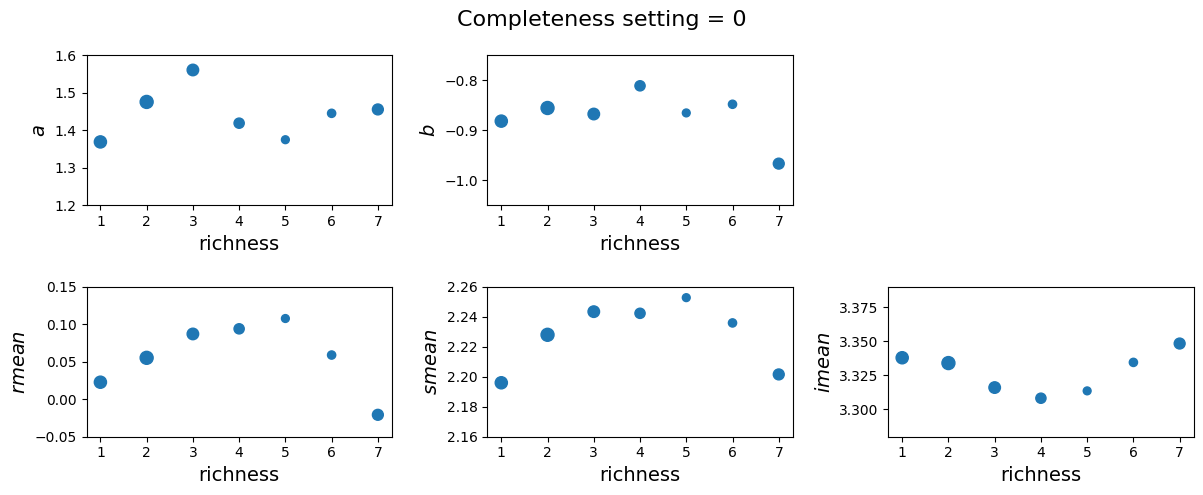

In [74]:
survey = 'SDSS'
COMPLETENESS_SETTING = 0

df_fp = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

columns = ['a', 'b', 'rmean', 'smean', 'imean']
ylims = [(1.2, 1.6), (-1.05, -0.75), (-0.05, 0.15), (2.16, 2.26), (3.28, 3.39)]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(FIGURE_WIDTH * 1.5, FIGURE_HEIGHT))
fig.axes[2].remove()

for i, col in enumerate(columns):
    ax = fig.axes[i]
    
    ax.scatter(df_fp['bin'], df_fp[col], s=df_fp['Ngal']/10)
    ax.set_ylabel(fr'${col}$', fontsize=14)
    ax.set_xlabel('richness', fontsize=14)
    ax.set_ylim(ylims[i])

fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
fig.tight_layout(h_pad=2., w_pad=2.)

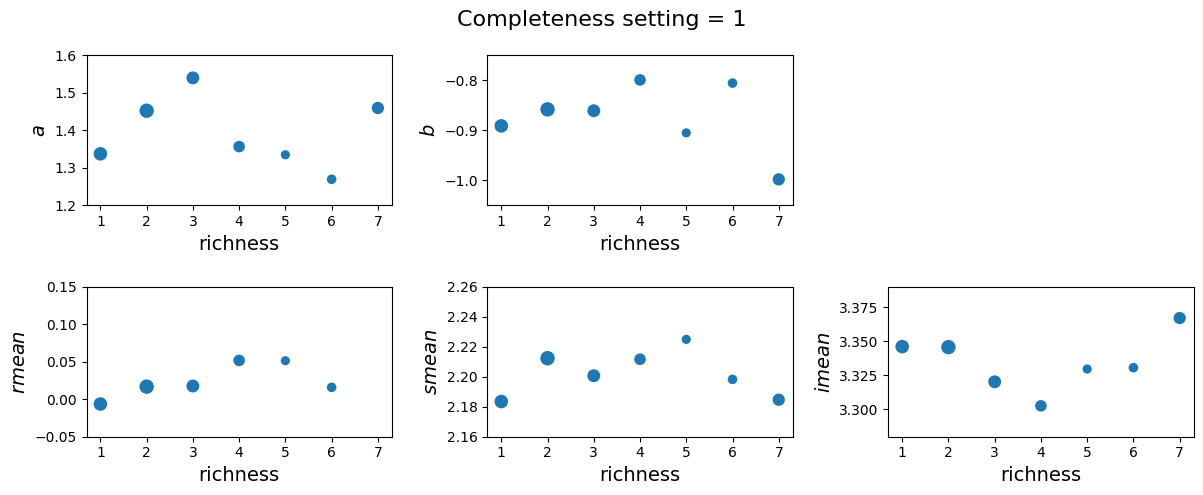

In [75]:
COMPLETENESS_SETTING = 1

df_fp = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

columns = ['a', 'b', 'rmean', 'smean', 'imean']
ylims = [(1.2, 1.6), (-1.05, -0.75), (-0.05, 0.15), (2.16, 2.26), (3.28, 3.39)]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(FIGURE_WIDTH * 1.5, FIGURE_HEIGHT))
fig.axes[2].remove()

for i, col in enumerate(columns):
    ax = fig.axes[i]
    
    ax.scatter(df_fp['bin'], df_fp[col], s=df_fp['Ngal']/10)
    ax.set_ylabel(fr'${col}$', fontsize=14)
    ax.set_xlabel('richness', fontsize=14)
    ax.set_ylim(ylims[i])

fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
fig.tight_layout(h_pad=2., w_pad=2.)

### Fit the logdist based on the previous fits

In [81]:
survey = 'SDSS'

COMPLETENESS_SETTING = 0

# Use the same bin edges as Cullan
richness_labels = list(range(1, len(richness_bins)))

df_full = pd.DataFrame()
# Load each bin
for bin_label in richness_labels:
    # Load data
    df = pd.read_csv(f'../scrap/richness_experiment/fp_sample_final/completeness_setting_{COMPLETENESS_SETTING}/bin_{bin_label}/{survey.lower()}.csv')
    
    # Rename logdist column
    df['logdist'] = df['logdist_mean_cf']
    
    # Load smin
    smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]
    
    # Get the FP parameters to be used for fitting
    FPparams = pd.read_csv(f'../scrap/richness_experiment/fp_fits/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv', index_col=0).loc[bin_label].to_numpy()[:-1]
    
    df = fit_logdist(
        survey=survey,
        df=df,
        smin=smin,
        FPparams=FPparams,
        save_posterior=False
            )
    
    # Rename logdist column (after richness correction)
    df['logdist_corr'] = df['logdist_mean_cf']
    
    # Save the output
    logdist_output_path = os.path.join(ROOT_PATH, f'scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')
    create_parent_folder(logdist_output_path)
    df_full = pd.concat([df_full, df])
    df_full.to_csv(logdist_output_path, index=False)

### Create logdist vs richness plot again

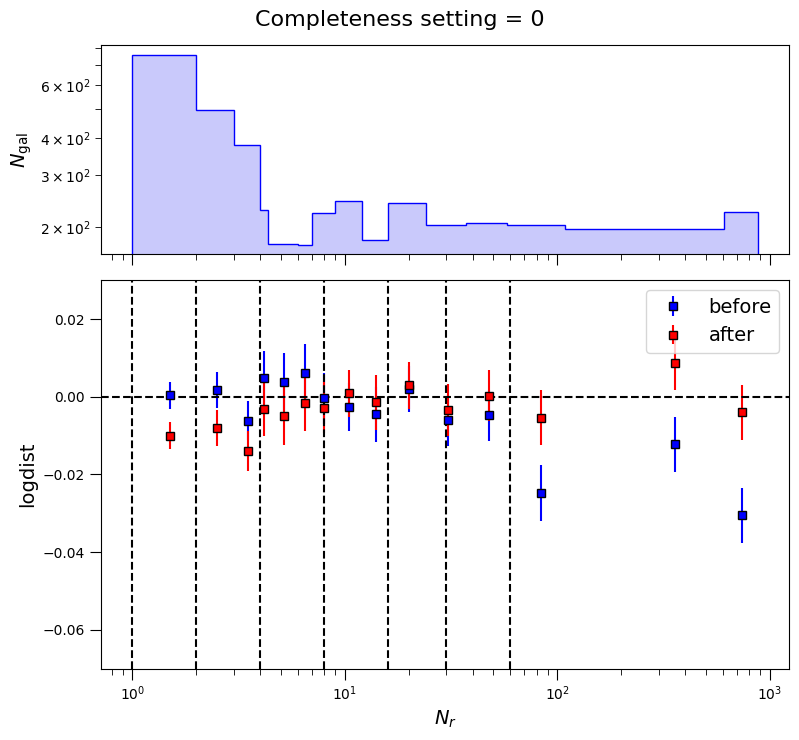

In [122]:
survey = 'SDSS'

COMPLETENESS_SETTING = 0

df = pd.read_csv(f'../scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=20, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist', 'mean'),
    logdist_rms=('logdist', 'std'),
    logdist_corr_mean=('logdist_corr', 'mean'),
    logdist_corr_rms=('logdist_corr', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])
df_grouped['logdist_corr_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_corr_mean'], yerr=df_grouped['logdist_corr_mean_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)
ax2.legend(fontsize=14)

# Use the same bin edges as Cullan
richness_bin = [1, 2, 4, 8, 16, 30, 60]
for x_ in richness_bin:
    ax2.axvline(x=x_, ls='--', c='k')

fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
fig.tight_layout()

### Plot corrected logdist vs redshift

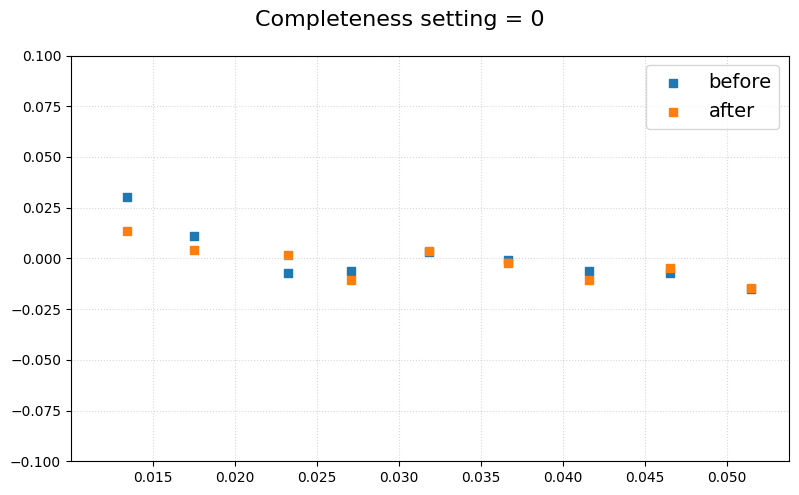

In [96]:
survey = 'SDSS'

COMPLETENESS_SETTING = 0

df = pd.read_csv(f'../scrap/richness_experiment/logdist/completeness_setting_{COMPLETENESS_SETTING}/{survey.lower()}.csv')

# Divide into redshift bins
z_bins = bin_list = np.linspace(df['z_dist_est'].min(), df['z_dist_est'].max(), 10)
z_bin_labels = list(range(1, len(z_bins)))
df['z_bin'] = pd.cut(df['z_dist_est'], z_bins, labels=z_bin_labels)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='z_bin', observed=False).agg(
    z_bin_count=('z_bin', 'count'),
    z_mean=('z_dist_est', 'mean'),
    logdist_median=('logdist', 'median'),
    logdist_rms=('logdist', 'std'),
    logdist_corr_median=('logdist_corr', 'median'),
    logdist_corr_rms=('logdist_corr', 'std')
)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# ax.scatter(df['z_dist_est'], df['logdist'])
# ax.scatter(df['z_dist_est'], df['logdist_corr'])
ax.scatter(df_grouped['z_mean'], df_grouped['logdist_median'], label='before', marker='s')
ax.scatter(df_grouped['z_mean'], df_grouped['logdist_corr_median'], label='after', marker='s')
ax.legend(fontsize=14)

ax.set_ylim(-0.1, 0.1)
ax.set_xlim(ZMIN, ZMAX)
ax.grid(ls=':', alpha=0.5)

fig.suptitle(f'Completeness setting = {COMPLETENESS_SETTING}', fontsize=16)
fig.tight_layout()

### Sanity check for single galaxies

In [115]:
survey = 'SDSS'
COMPLETENESS_SETTING = 1

df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_0/{survey.lower()}.csv')
df = df[df['Nr'] == 1]
df['logdist'] = df['logdist_mean_cf']

outlier_output_filepath = os.path.join(ROOT_PATH, 'scrap/richness_experiment/test/sdss.csv')
create_parent_folder(outlier_output_filepath)

smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

fp_params = fit_FP(
    survey=survey,
    df=df,
    outlier_output_filepath=outlier_output_filepath,
    smin=smin,
    use_completeness_model=False
)

df = pd.read_csv(outlier_output_filepath)

df = fit_logdist(
    survey=survey,
    df=df,
    smin=smin,
    FPparams=fp_params,
)

df['logdist_corr'] = df['logdist_mean_cf']

In [116]:
df[['logdist', 'logdist_mean_cf']].mean()

logdist            0.007196
logdist_mean_cf   -0.010019
dtype: float64

# 3. LAMOST

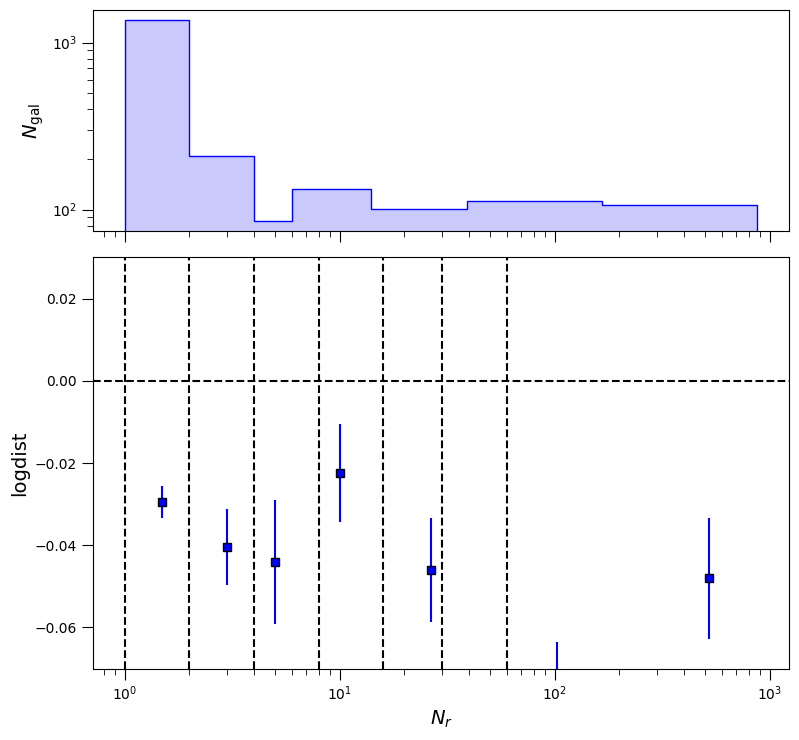

In [137]:
df = pd.read_csv('../data/foundation/logdist/smin_setting_1/completeness_setting_1/fp_setting_0/LAMOST.csv')

# Divide into richness classes (10% quantile)
qcut_, qcut_bins = pd.qcut(x=df['Nr'], q=20, duplicates='drop', retbins=True)
df['richness_class'] = pd.cut(df['Nr'], qcut_bins, labels=range(1, len(qcut_bins)), right=False)

# Group by class, count each bin and average logdist
df_grouped = df.groupby(by='richness_class', observed=False).agg(
    richness_count=('Nr', 'count'),
    logdist_mean=('logdist_mean_cf', 'mean'),
    logdist_rms=('logdist_mean_cf', 'std')
)
df_grouped['bin_center'] = (qcut_bins[1:] + qcut_bins[:-1]) / 2
df_grouped['logdist_mean_stderr'] = df_grouped['logdist_rms'] / np.sqrt(df_grouped['richness_count'])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, 
                               gridspec_kw={"height_ratios": (.35, .65)}, 
                               figsize=(FIGURE_WIDTH, FIGURE_HEIGHT * 1.5))

# Top figure: histogram of richness
ax1.hist(df['Nr'], bins=qcut_bins, edgecolor='blue', histtype='stepfilled', color='#c9c9fb')
ax1.set_yscale('log')
ax1.set_ylabel(r'$N_\mathrm{gal}$', fontsize=14)
ax1.tick_params(axis='both', length=8.0)
ax1.tick_params(which='minor', length=4.0)

# Bottom figure: mean logdist vs richness
ax2.errorbar(x=df_grouped['bin_center'], y=df_grouped['logdist_mean'], yerr=df_grouped['logdist_mean_stderr'], fmt='s', mec='k', mfc='b', ecolor='b')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel(r'$N_r$', fontsize=14)
ax2.set_ylabel(r'logdist', fontsize=14)
ax2.set_ylim(-0.07, 0.03)
ax2.tick_params(axis='both', length=8.0)
ax2.tick_params(which='minor', length=4.0)

# Use the same bin edges as Cullan
richness_bin = [1, 2, 4, 8, 16, 30, 60]
for x_ in richness_bin:
    ax2.axvline(x=x_, ls='--', c='k')

fig.tight_layout()

(-0.8, 0.8)

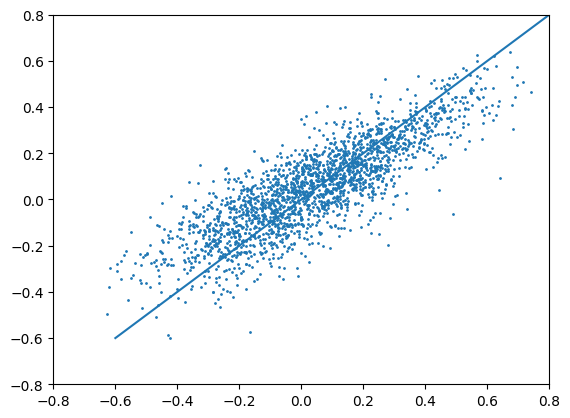

In [150]:
fp_params = pd.read_csv('../artifacts/fp_fit/smin_setting_1/completeness_setting_1/fp_fits.csv', index_col=0).loc['LAMOST'].to_numpy()

df = pd.read_csv('../data/foundation/fp_sample_final/smin_setting_1/completeness_setting_1/lamost.csv')

plt.scatter(fp_params[0] * df['s'] + fp_params[1] * df['i'] + fp_params[2] - fp_params[0] * fp_params[3] - fp_params[1] * fp_params[4], df['r'], s=1)
plt.plot([-0.6, 0.8], [-0.6, 0.8])
plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

(-0.8, 0.8)

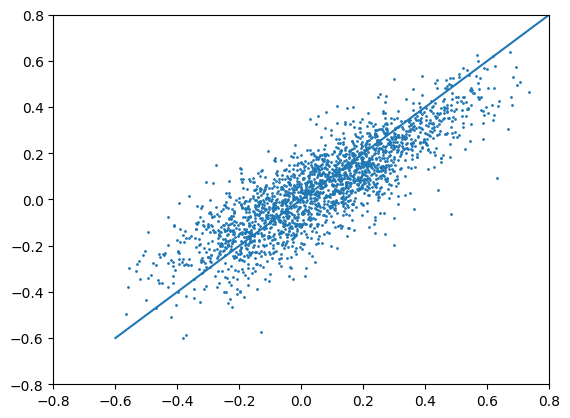

In [153]:
fp_params = pd.read_csv('../artifacts/fp_fit/smin_setting_1/completeness_setting_1/fp_fits.csv', index_col=0).loc['6dFGS'].to_numpy()

df = pd.read_csv('../data/foundation/fp_sample_final/smin_setting_1/completeness_setting_1/lamost.csv')

plt.scatter(fp_params[0] * df['s'] + fp_params[1] * df['i'] + fp_params[2] - fp_params[0] * fp_params[3] - fp_params[1] * fp_params[4], df['r'], s=1)
plt.plot([-0.6, 0.8], [-0.6, 0.8])
plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

### One last sanity check. Use Cullan's binning

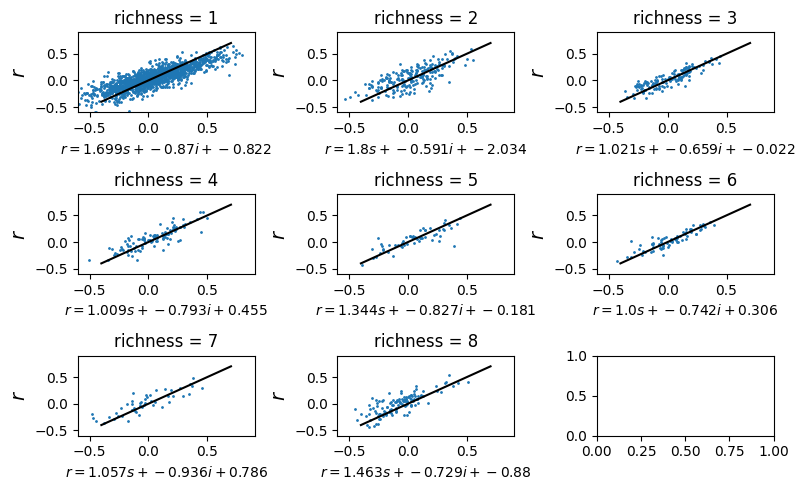

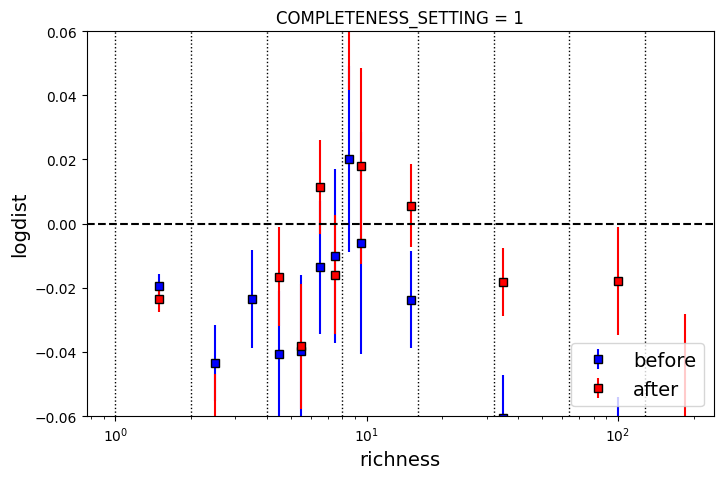

In [132]:
survey = 'LAMOST'

# Use the same richness bins that Cullan used (for fitting)
richness_bins = np.array([1, 2, 4, 8, 16, 32, 64, 128, np.inf])

# Use custom richness bins for plotting and aggregation
richness_bins_plot = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 150, 220])

for FP_SETTING in [0]:
    # Load groups and clusters data
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/completeness_setting_{COMPLETENESS_SETTING}/fp_setting_{FP_SETTING}/{survey.lower()}.csv')
    df = df[df['Nr'] > 0]
    df['logdist'] = df['logdist_mean_cf']
    df['logdist_err'] = df['logdist_std_cf']

    # Use the same richness bins that Cullan used
    richness_labels = list(range(1, len(richness_bins)))
    richness_plot_labels = list(range(1, len(richness_bins_plot)))
    df['richness_class'] = pd.cut(df['Nr'], bins=richness_bins, right=False, labels=richness_labels)
    df['richness_plot'] = pd.cut(df['Nr'], bins=richness_bins_plot, right=False, labels=richness_plot_labels)

    # List to store the stuff
    fp_params = []
    df_final = pd.DataFrame()

    # Plot the r vs predicted r
    ncols = 3
    nbins = len(richness_labels)
    nrows = int(np.ceil(nbins / ncols))
    fig, axs = plt.subplots(ncols=3, nrows=nrows, figsize=DEFAULT_FIGSIZE)
    
    # Loop through each richness class
    for i, richness in enumerate(richness_labels):
        df_fit = df.copy()
        df_fit = df_fit[df_fit['richness_class'] == richness]

        # Get veldisp limit
        smin = SURVEY_VELDISP_LIMIT[SMIN_SETTING][survey]

        # Get completeness setting
        use_completeness_model = True if COMPLETENESS_SETTING == 1 else False
        completeness_model_filepath = f"../artifacts/fp_fit/smin_setting_{SMIN_SETTING}/completeness.csv" if use_completeness_model else None

        # Fit the FP
        params = fit_FP('6dFGS', df_fit, '../scrap/sampah.csv', smin, use_completeness_model, completeness_model_filepath)
        a, b, rmean, smean, imean, s1, s2, s3 = params
        c = rmean - (a * smean) - (b * imean)
        
        # Plot the r vs predicted r
        ax = fig.axes[i]
        ax.scatter(a * df_fit['s'] + b * df_fit['i'] + c, df_fit['r'], s=1)
        ax.plot([-0.4, 0.7], [-0.4, 0.7], color='k')
        ax.set_xlabel(fr'$r = {np.round(a, 3)}s + {np.round(b, 3)}i + {np.round(c, 3)}$', fontsize=10)
        ax.set_ylabel(r'$r$', fontsize=14)
        ax.set_title(f'richness = {richness}')
        ax.set_xlim(-0.6, 0.9)
        ax.set_ylim(-0.6, 0.9)
        fig.tight_layout()
        
        # Fit the logdist
        df_fit = fit_logdist('6dFGS', df_fit, smin, params)

        # Save the stuff
        fp_params.append(params)
        df_final = pd.concat([df_final, df_fit])

    df_grouped = df_final.groupby(by='richness_plot', observed=False).agg(
        Ngal=('Nr', 'count'),
        richness_median=('Nr', 'median'),
        logdist_median=('logdist', 'median'),
        logdist_corr_median=('logdist_mean_cf', 'median'),
        logdist_std=('logdist', 'std'),
        logdist_corr_std=('logdist_mean_cf', 'std')
    )
    df_grouped['logdist_stderr'] = df_grouped['logdist_std'] / np.sqrt(df_grouped['Ngal'])
    df_grouped['logdist_corr_stderr'] = df_grouped['logdist_corr_std'] / np.sqrt(df_grouped['Ngal'])

    bin_center = (richness_bins_plot[1:] + richness_bins_plot[:-1]) / 2

    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    ax.errorbar(bin_center, df_grouped['logdist_median'], yerr=df_grouped['logdist_stderr'], fmt='s', mec='k', mfc='b', ecolor='b', label='before')
    ax.errorbar(bin_center, df_grouped['logdist_corr_median'], yerr=df_grouped['logdist_corr_stderr'], fmt='s', mec='k', mfc='r', ecolor='r', label='after')
    ax.set_xscale('log')
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlabel('richness', fontsize=14)
    ax.set_ylabel('logdist', fontsize=14)
    ax.set_title(f'COMPLETENESS_SETTING = {COMPLETENESS_SETTING}')
    ax.set_ylim(-0.06, 0.06)
    ax.legend(fontsize=14, loc='lower right')

    for x_ in richness_bins:
        ax.axvline(x=x_, ls=':', color='k', lw=1)